In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits
%matplotlib inline
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [3]:
#test whether a time series is stationary by ADF test
def augmented_dickey_fuller_statistics(time_series):
    result = adfuller(time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [4]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))*100  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    
    
    return({'MAPE': mape, 'ME':me, 'MAE': mae, 
            'MPE': mpe, 'RMSE':rmse})

In [5]:
#convert back to original data after 3rd difference
def invert_transformation1 (forecast, df_diff2, df_diff1, df_log): 
    df_diff2_fc = forecast + df_diff2.shift()
    df_diff1_fc = df_diff2_fc + df_diff1.shift()
    df_log_fc = df_diff1_fc + df_log.shift()
    df_fc = np.exp(df_log_fc)
    return df_fc

In [6]:
#The data in ma_lga_12345.csv has been resampled to quartely intervals with a median aggregator outside of this notebook
#We will load it and visualise it first
df=pd.read_csv('ma.csv')
df.head(5)

,saledate,MA,type,bedrooms
0,30/09/2007,441854,house,2
1,31/12/2007,441854,house,2
2,31/03/2008,441854,house,2
3,30/06/2008,441854,house,2
4,30/09/2008,451583,house,2


In [7]:
#Let's limit the scope of this problem to houses only
df_house = df[df.type=='house'] 
df_house['saledate'] = pd.to_datetime(df_house['saledate'])
df_house.head()

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,saledate,MA,type,bedrooms
0,2007-09-30,441854,house,2
1,2007-12-31,441854,house,2
2,2008-03-31,441854,house,2
3,2008-06-30,441854,house,2
4,2008-09-30,451583,house,2


In [8]:
#group by number of bedroom
df_house = pd.pivot_table(df_house, values = 'MA', index='saledate', columns = 'bedrooms')
df_house.head()

bedrooms,2,3,4,5
saledate,,,,
2007-03-31,NaN,421291.0,548969.0,NaN
2007-06-30,NaN,421291.0,548969.0,NaN
2007-09-30,441854.0,421291.0,548969.0,735904.0
2007-12-31,441854.0,421291.0,548969.0,735904.0
2008-03-31,441854.0,416031.0,552484.0,735904.0


In [9]:
#check NA value
df_house.isnull().sum().sum()

4

In [10]:
#exclude the first 2 observations
df_house = df_house.loc['2007-09-30':]
df_house = pd.DataFrame(df_house.to_records())
df_house = df_house.set_index(pd.DatetimeIndex(df_house['saledate']))

del df_house['saledate']
df_house.columns = ['br2', 'br3', 'br4', 'br5']
df_house.head()


,br2,br3,br4,br5
saledate,,,,
2007-09-30,441854.0,421291.0,548969.0,735904.0
2007-12-31,441854.0,421291.0,548969.0,735904.0
2008-03-31,441854.0,416031.0,552484.0,735904.0
2008-06-30,441854.0,419628.0,559580.0,735904.0
2008-09-30,451583.0,423811.0,561852.0,758340.0


In [11]:
df_test = df_house.loc['2018-03-31':]

In [12]:
df_house_copy = df_house.copy()
df_house_copy['estimated_br5'] = df_house_copy['br4']*0.5 + df_house_copy['br3']
df_house_copy.head()

,br2,br3,br4,br5,estimated_br5
saledate,,,,,
2007-09-30,441854.0,421291.0,548969.0,735904.0,695775.5
2007-12-31,441854.0,421291.0,548969.0,735904.0,695775.5
2008-03-31,441854.0,416031.0,552484.0,735904.0,692273.0
2008-06-30,441854.0,419628.0,559580.0,735904.0,699418.0
2008-09-30,451583.0,423811.0,561852.0,758340.0,704737.0


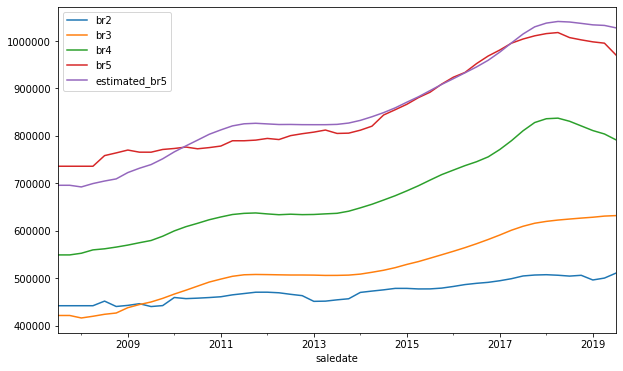

In [13]:
#Plot the data
%matplotlib inline 
df_house_copy.plot(figsize=(10,6))

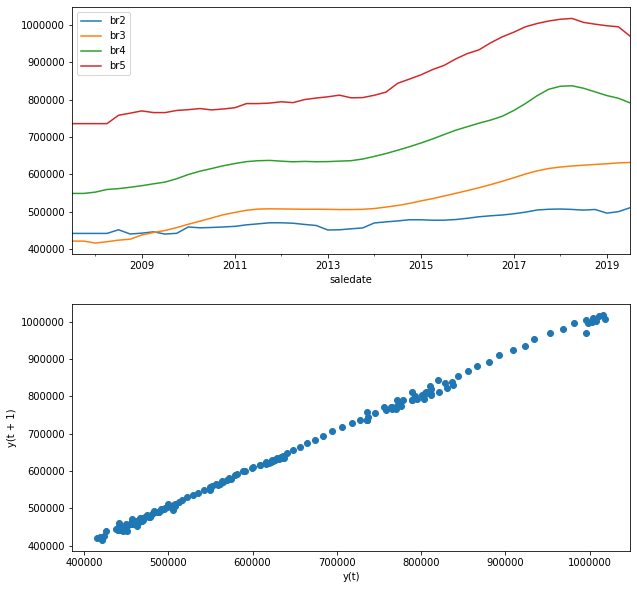

In [14]:
#plot data
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
df_house.plot(ax=ax1)
pd.plotting.lag_plot(df_house)
plt.savefig('fig1.png')
plt.show()

In [15]:
#delete data of the bedroom 5
df_house_234 = df_house.drop(["br5"], axis=1)
df_house_234.head()

,br2,br3,br4
saledate,,,
2007-09-30,441854.0,421291.0,548969.0
2007-12-31,441854.0,421291.0,548969.0
2008-03-31,441854.0,416031.0,552484.0
2008-06-30,441854.0,419628.0,559580.0
2008-09-30,451583.0,423811.0,561852.0


In [16]:
df_house_234.describe()

,br2,br3,br4
count,49.000000,49.000000,49.000000
mean,471453.979592,522319.653061,674735.836735
std,21955.003069,65953.154501,90320.501311
min,440123.000000,416031.000000,548969.000000
25%,454270.000000,483176.000000,615603.000000
50%,469920.000000,507449.000000,637421.000000
75%,489104.000000,572582.000000,745430.000000
max,510712.000000,631875.000000,837295.000000


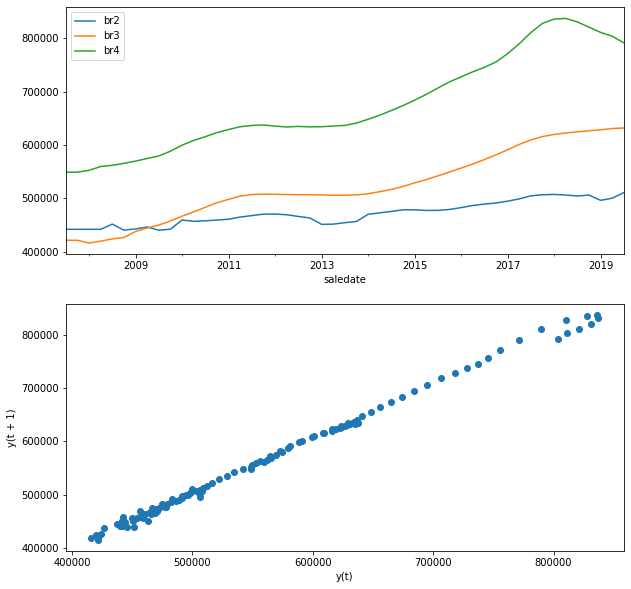

In [17]:
#plot data
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
df_house_234.plot(ax=ax1)
pd.plotting.lag_plot(df_house_234)
plt.savefig('fig1.png')
plt.show()


In [18]:
#split dataset
df_house_train = df_house_234.loc[:'2017-12-31']
df_house_test = df_house_234.loc['2018-03-31':]

In [19]:
#test stationary, if p-value < 0.05 stationary
print('Augmented Dickey-Fuller Test: Bedroom 2 Time Series')
augmented_dickey_fuller_statistics(df_house_train['br2'])
print('Augmented Dickey-Fuller Test: Bedroom 3 Time Series')
augmented_dickey_fuller_statistics(df_house_train['br3'])
print('Augmented Dickey-Fuller Test: Bedroom 4 Time Series')
augmented_dickey_fuller_statistics(df_house_train['br4'])

Augmented Dickey-Fuller Test: Bedroom 2 Time Series
ADF Statistic: 0.079670
p-value: 0.964645
Critical Values:
	1%: -3.601
	5%: -2.935
	10%: -2.606
Augmented Dickey-Fuller Test: Bedroom 3 Time Series
ADF Statistic: 2.130822
p-value: 0.998821
Critical Values:
	1%: -3.661
	5%: -2.961
	10%: -2.619
Augmented Dickey-Fuller Test: Bedroom 4 Time Series
ADF Statistic: 1.354250
p-value: 0.996896
Critical Values:
	1%: -3.610
	5%: -2.939
	10%: -2.608


In [20]:
# taking log and 1st difference
df_house_log = np.log(df_house_train)
df_house_diff1 = df_house_log.diff().dropna()

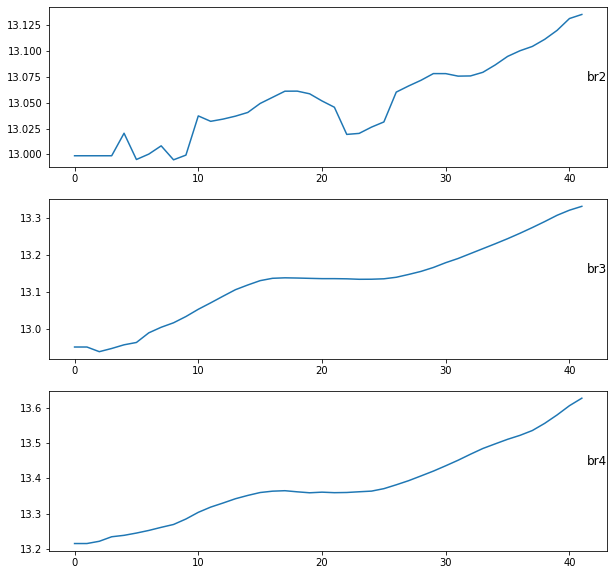

In [21]:
values = df_house_log.values
# specify columns to plot
groups = [0, 1, 2]
i = 1
# plot each column
plt.figure(figsize=(10,10))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df_house_log.columns[group], y=0.5, loc='right')
	i += 1
plt.savefig('fig2.png')
plt.show()

In [22]:
#chech stationary of 1st differenced data
print('Augmented Dickey-Fuller Test: Bedroom 2 Time Series')
augmented_dickey_fuller_statistics(df_house_diff1['br2'])
print('Augmented Dickey-Fuller Test: Bedroom 3 Time Series')
augmented_dickey_fuller_statistics(df_house_diff1['br3'])
print('Augmented Dickey-Fuller Test: Bedroom 4 Time Series')
augmented_dickey_fuller_statistics(df_house_diff1['br4'])

Augmented Dickey-Fuller Test: Bedroom 2 Time Series
ADF Statistic: -6.393407
p-value: 0.000000
Critical Values:
	1%: -3.606
	5%: -2.937
	10%: -2.607
Augmented Dickey-Fuller Test: Bedroom 3 Time Series
ADF Statistic: -3.889311
p-value: 0.002115
Critical Values:
	1%: -3.661
	5%: -2.961
	10%: -2.619
Augmented Dickey-Fuller Test: Bedroom 4 Time Series
ADF Statistic: -1.491994
p-value: 0.537468
Critical Values:
	1%: -3.610
	5%: -2.939
	10%: -2.608


In [23]:
# br3 is non-stationary, take 2nd difference
df_house_diff2 = df_house_diff1.diff().dropna()
print('Augmented Dickey-Fuller Test: Bedroom 2 Time Series')
augmented_dickey_fuller_statistics(df_house_diff2['br2'])
print('Augmented Dickey-Fuller Test: Bedroom 3 Time Series')
augmented_dickey_fuller_statistics(df_house_diff2['br3'])
print('Augmented Dickey-Fuller Test: Bedroom 4 Time Series')
augmented_dickey_fuller_statistics(df_house_diff2['br4'])

Augmented Dickey-Fuller Test: Bedroom 2 Time Series
ADF Statistic: -10.475838
p-value: 0.000000
Critical Values:
	1%: -3.610
	5%: -2.939
	10%: -2.608
Augmented Dickey-Fuller Test: Bedroom 3 Time Series
ADF Statistic: -2.552202
p-value: 0.103284
Critical Values:
	1%: -3.627
	5%: -2.946
	10%: -2.612
Augmented Dickey-Fuller Test: Bedroom 4 Time Series
ADF Statistic: -5.533762
p-value: 0.000002
Critical Values:
	1%: -3.610
	5%: -2.939
	10%: -2.608


In [24]:
#br2 is non-stationary, take 3rd difference
df_house_diff3 = df_house_diff2.diff().dropna()
print('Augmented Dickey-Fuller Test: Bedroom 2 Time Series')
augmented_dickey_fuller_statistics(df_house_diff3['br2'])
print('Augmented Dickey-Fuller Test: Bedroom 3 Time Series')
augmented_dickey_fuller_statistics(df_house_diff3['br3'])
print('Augmented Dickey-Fuller Test: Bedroom 4 Time Series')
augmented_dickey_fuller_statistics(df_house_diff3['br4'])

Augmented Dickey-Fuller Test: Bedroom 2 Time Series
ADF Statistic: -12.554320
p-value: 0.000000
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610
Augmented Dickey-Fuller Test: Bedroom 3 Time Series
ADF Statistic: -4.921247
p-value: 0.000032
Critical Values:
	1%: -3.639
	5%: -2.951
	10%: -2.614
Augmented Dickey-Fuller Test: Bedroom 4 Time Series
ADF Statistic: -8.914934
p-value: 0.000000
Critical Values:
	1%: -3.616
	5%: -2.941
	10%: -2.609


In [148]:
#Initiate VAR model
model = VAR(df_house_diff3)
res = model.select_order(9)
res.summary()

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


,AIC,BIC,FPE,HQIC
0,-31.48,-31.34,2.121e-14,-31.44
1,-32.58,-32.02,7.134e-15,-32.40
2,-33.03,-32.05,4.636e-15,-32.72
3,-32.95,-31.55,5.299e-15,-32.50
4,-33.23,-31.40,4.467e-15,-32.64
5,-33.02,-30.78,6.588e-15,-32.31
6,-33.34,-30.67,6.575e-15,-32.49
7,-34.00,-30.92,5.791e-15,-33.01
8,-36.59,-33.08,1.156e-15,-35.47
9,-75.56*,-71.64*,1.376e-31*,-74.31*


In [149]:
model_fitted = model.fit(9)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 23, Jul, 2020
Time:                     12:14:14
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -71.6392
Nobs:                     30.0000    HQIC:                  -74.3075
Log likelihood:           1089.73    FPE:                1.37635e-31
AIC:                     -75.5626    Det(Omega_mle):    -9.87274e-33
--------------------------------------------------------------------
Results for equation br2
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.000153         0.000436            0.352           0.725
L1.br2        -0.685747         0.158322           -4.331           0.000
L1.br3        -1.580327         0.696652           -2.268           0.023
L1.br4        -0

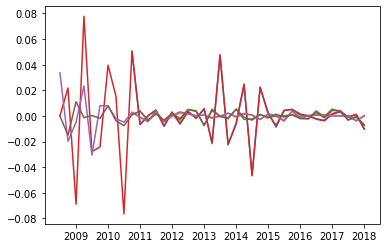

In [27]:
#plot in-sample forecast values
plt.plot(model_fitted.fittedvalues)
plt.plot(df_house_diff3)

In [28]:
data_fitted = invert_transformation1 (model_fitted.fittedvalues, df_house_diff2, df_house_diff1, df_house_log)

In [29]:
data_fitted.tail()

,br2,br3,br4
saledate,,,
2016-12-31,491218.851649,582126.847109,756561.685860
2017-03-31,493997.377090,590930.262011,770457.157272
2017-06-30,498892.257916,601172.548917,789958.883457
2017-09-30,504664.200307,609552.444084,811042.874215
2017-12-31,506618.048184,616087.580455,828553.315658


In [30]:
df_house_train.tail()

,br2,br3,br4
saledate,,,
2016-12-31,491152.0,581485.0,755683.0
2017-03-31,494544.0,590949.0,771216.0
2017-06-30,498846.0,601041.0,789732.0
2017-09-30,504592.0,609355.0,810694.0
2017-12-31,506578.0,615743.0,828058.0


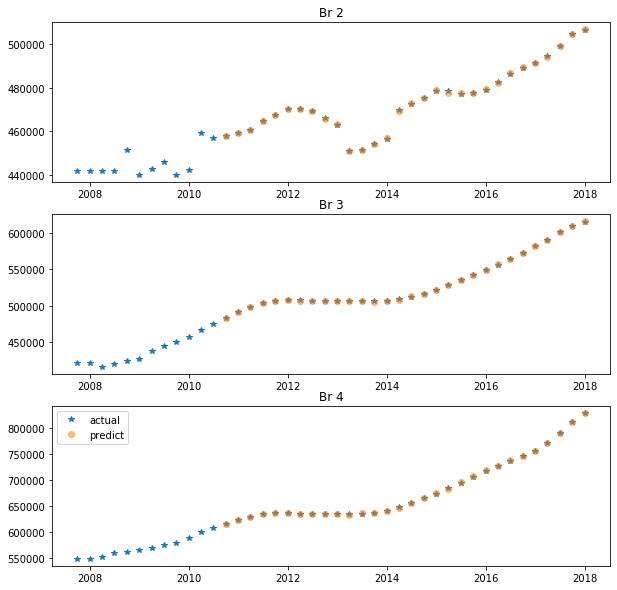

In [31]:
#Plot in-sample fit vs actual values
fig, axs = plt.subplots(3, 1, figsize=(10,10))
axs[0].plot(df_house_train.br2, '*', label = 'actual')
axs[0].plot(data_fitted.br2, 'o', alpha = 0.5, label = 'predict')
axs[0].set_title('Br 2')

axs[1].plot(df_house_train.br3, '*', label = 'actual')
axs[1].plot(data_fitted.br3, 'o', alpha = 0.5, label = 'predict')
axs[1].set_title('Br 3')

axs[2].plot(df_house_train.br4, '*', label = 'actual')
axs[2].plot(data_fitted.br4, 'o', alpha = 0.5, label = 'predict')
axs[2].set_title('Br 4')
plt.legend(loc="upper left")
plt.savefig('fig3.png')

Text(0, 0.5, 'Predict')

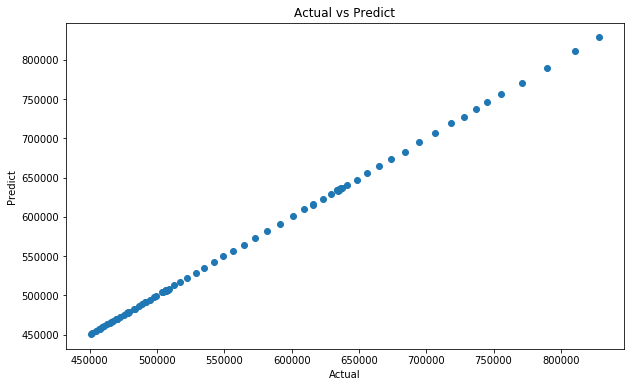

In [32]:
plt.figure(figsize=(10,6))
plt.scatter(df_house_train,data_fitted)
plt.title("Actual vs Predict")
plt.xlabel('Actual')
plt.ylabel('Predict')

In [33]:
forecast_accuracy(data_fitted, df_house_train[9:])

{'MAPE': br2    0.043713
 br3    0.042637
 br4    0.064243
 dtype: float64,
 'ME': br2     0.172715
 br3    11.515865
 br4    19.105093
 dtype: float64,
 'MAE': br2    207.103138
 br3    228.560930
 br4    442.989615
 dtype: float64,
 'MPE': br2    1.619921e-07
 br3    1.337817e-07
 br4    3.222072e-07
 dtype: float64,
 'RMSE': br2    270.658425
 br3    279.138051
 br4    553.247138
 dtype: float64}

In [34]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

9


In [35]:
# Input data for forecasting
forecast_input = df_house_diff3.values[-lag_order:]
forecast_input

array([[ 7.00179936e-04, -1.93325882e-03, -2.12701231e-03],
       [ 3.01047184e-04, -4.23797814e-05, -2.31928890e-03],
       [-2.50799460e-03,  5.16428309e-04,  2.86579856e-03],
       [-3.89266929e-03,  4.33725029e-04, -1.46756968e-03],
       [ 1.48767729e-03, -1.21758433e-04,  4.21075698e-03],
       [ 3.99526563e-03, -8.54834358e-05,  4.18265259e-03],
       [-9.25135961e-04,  7.35662382e-05, -3.30712737e-03],
       [ 1.01261471e-03, -3.98445330e-03, -9.06777411e-04],
       [-1.03160692e-02, -1.13657156e-04, -7.47636039e-03]])

In [36]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=len(df_house_test))
df_forecast_3d = pd.DataFrame(fc, index=df_house_test.index, columns=df_house_test.columns)
df_forecast_3d

,br2,br3,br4
saledate,,,
2018-03-31,0.033908,0.000739,-0.007200
2018-06-30,-0.035374,-0.001779,-0.002156
2018-09-30,0.013702,0.003591,0.000020
2018-12-31,-0.004024,0.000049,0.011598
2019-03-31,-0.045551,0.002741,0.014937
2019-06-30,0.074731,0.000916,0.015578
2019-09-30,-0.060880,-0.002595,0.002185


In [37]:
# inverting transformation
def invert_transformation_dynamic(train, forecast):
    fc_df = forecast.copy()
    columns = train.columns
    for col in columns:
        fc_df[str(col)] = train[col].iloc[-1] + fc_df[str(col)].cumsum()
    return fc_df

In [39]:
df_forecast_2d = invert_transformation_dynamic(df_house_diff2, df_forecast_3d)
df_forecast_1d = invert_transformation_dynamic(df_house_diff1, df_forecast_2d)
df_forecast_log = invert_transformation_dynamic(df_house_log, df_forecast_1d)
df_forecast = np.exp(df_forecast_log)

In [40]:
df_forecast

,br2,br3,br4
saledate,,,
2018-03-31,522168.068207,620600.525220,835533.776827
2018-06-30,533420.370339,622781.524401,831056.056297
2018-09-30,547488.372590,624496.114083,814832.929961
2018-12-31,562313.725605,625771.259356,796738.404863
2019-03-31,552202.760562,628324.303420,788604.119808
2019-06-30,558714.495991,632750.252649,802534.843700
2019-09-30,548040.997271,637432.129184,841548.439498


In [41]:
forecast_accuracy(df_forecast.values, df_house_test.values)

{'MAPE': 3.5642200648016513,
 'ME': 13368.927134874582,
 'MAE': 20205.993009570448,
 'MPE': 0.027278255013898096,
 'RMSE': 29196.716105431038}

In [42]:
df_forecast_copy = df_forecast.copy()
df_forecast_copy['br5'] = df_forecast_copy ['br4']*1.25
df_forecast_copy

,br2,br3,br4,br5
saledate,,,,
2018-03-31,522168.068207,620600.525220,835533.776827,1.044417e+06
2018-06-30,533420.370339,622781.524401,831056.056297,1.038820e+06
2018-09-30,547488.372590,624496.114083,814832.929961,1.018541e+06
2018-12-31,562313.725605,625771.259356,796738.404863,9.959230e+05
2019-03-31,552202.760562,628324.303420,788604.119808,9.857551e+05
2019-06-30,558714.495991,632750.252649,802534.843700,1.003169e+06
2019-09-30,548040.997271,637432.129184,841548.439498,1.051936e+06


In [43]:
df_forecast_copy.values

array([[ 522168.06820703,  620600.52521951,  835533.77682707,
        1044417.22103384],
       [ 533420.37033923,  622781.5244012 ,  831056.05629724,
        1038820.07037155],
       [ 547488.37258956,  624496.11408295,  814832.92996126,
        1018541.16245158],
       [ 562313.72560528,  625771.25935649,  796738.4048632 ,
         995923.006079  ],
       [ 552202.76056215,  628324.30342014,  788604.11980765,
         985755.14975956],
       [ 558714.49599112,  632750.25264922,  802534.8436997 ,
        1003168.55462463],
       [ 548040.9972707 ,  637432.12918389,  841548.43949779,
        1051935.54937223]])

In [44]:
df_test.values

array([[ 507248.,  619638.,  836056., 1015529.],
       [ 506116.,  622466.,  837295., 1017752.],
       [ 504318.,  624602.,  830727., 1007114.],
       [ 506001.,  626608.,  820924., 1002323.],
       [ 496133.,  628423.,  811121.,  998136.],
       [ 500158.,  630814.,  803925.,  995363.],
       [ 510712.,  631875.,  791446.,  970268.]])

In [45]:
forecast_accuracy(df_forecast_copy, df_test)

{'MAPE': br2    8.334792
 br3    0.222662
 br4    2.135206
 br5    2.447067
 dtype: float64,
 'ME': br2    41951.827224
 br3     1104.301188
 br4    -2949.347007
 br5    18867.959099
 dtype: float64,
 'MAE': br2    41951.827224
 br3     1401.822085
 br4    17264.329720
 br5    24233.914574
 dtype: float64,
 'MPE': br2    0.083348
 br3    0.001752
 br4   -0.003265
 br5    0.019102
 dtype: float64,
 'RMSE': br2    44671.941528
 br3     2279.657157
 br4    23591.640414
 br5    34504.106637
 dtype: float64}

In [46]:
forecast_accuracy(df_forecast_copy.values, df_test.values)

{'MAPE': 3.2849316830867483,
 'ME': 14743.685125884105,
 'MAE': 21212.9734005803,
 'MPE': 0.025234276717108036,
 'RMSE': 30609.957811300425}

In [47]:
forecast_accuracy(df_forecast.values, df_house_test.values)

{'MAPE': 3.5642200648016513,
 'ME': 13368.927134874582,
 'MAE': 20205.993009570448,
 'MPE': 0.027278255013898096,
 'RMSE': 29196.716105431038}

In [48]:
df_house_test

,br2,br3,br4
saledate,,,
2018-03-31,507248.0,619638.0,836056.0
2018-06-30,506116.0,622466.0,837295.0
2018-09-30,504318.0,624602.0,830727.0
2018-12-31,506001.0,626608.0,820924.0
2019-03-31,496133.0,628423.0,811121.0
2019-06-30,500158.0,630814.0,803925.0
2019-09-30,510712.0,631875.0,791446.0


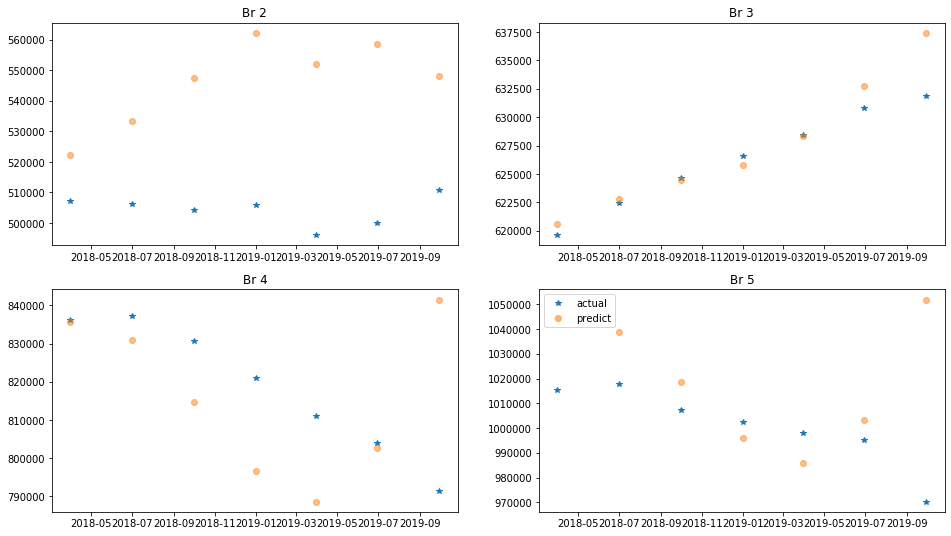

In [49]:
fig, axs = plt.subplots(2, 2, figsize=(16,9))
axs[0, 0].plot(df_test.br2, '*', label = 'actual')
axs[0, 0].plot(df_forecast_copy.br2, 'o', alpha = 0.5, label = 'predict')
axs[0, 0].set_title('Br 2')

axs[0, 1].plot(df_test.br3, '*', label = 'actual')
axs[0, 1].plot(df_forecast_copy.br3, 'o', alpha = 0.5, label = 'predict')
axs[0, 1].set_title('Br 3')

axs[1, 0].plot(df_test.br4, '*', label = 'actual')
axs[1, 0].plot(df_forecast_copy.br4, 'o', alpha = 0.5, label = 'predict')
axs[1, 0].set_title('Br 4')

axs[1, 1].plot(df_test.br5, '*', label = 'actual')
axs[1, 1].plot(df_forecast_copy.br5, 'o', alpha = 0.5, label = 'predict')
axs[1, 1].set_title('Br 5')

plt.legend(loc="upper left")
plt.savefig('fig5.png')

AttributeError: 'DataFrame' object has no attribute 'br5'

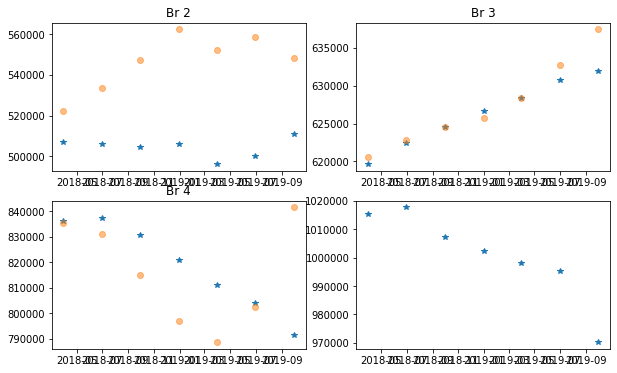

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(10,6))
axs[0, 0].plot(df_test.br2, '*', label = 'actual')
axs[0, 0].plot(df_forecast.br2, 'o', alpha = 0.5, label = 'predict')
axs[0, 0].set_title('Br 2')

axs[0, 1].plot(df_test.br3, '*', label = 'actual')
axs[0, 1].plot(df_forecast.br3, 'o', alpha = 0.5, label = 'predict')
axs[0, 1].set_title('Br 3')

axs[1, 0].plot(df_test.br4, '*', label = 'actual')
axs[1, 0].plot(df_forecast.br4, 'o', alpha = 0.5, label = 'predict')
axs[1, 0].set_title('Br 4')

axs[1, 1].plot(df_test.br5, '*', label = 'actual')
axs[1, 1].plot(df_forecast.br5, 'o', alpha = 0.5, label = 'predict')
axs[1, 1].set_title('Br 5')

plt.legend(loc="upper left")

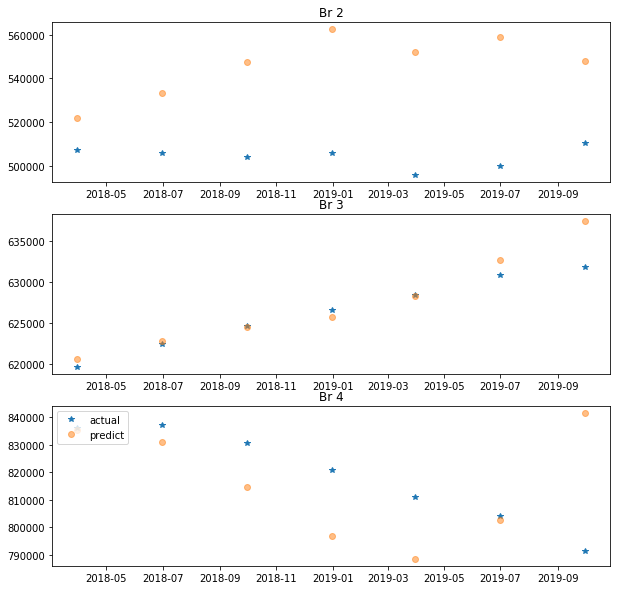

In [426]:
#Plot out-of-sample forecast vs actual values
fig, axs = plt.subplots(3, 1, figsize=(10,10))
axs[0].plot(df_house_test.br2, '*', label = 'actual')
axs[0].plot(df_forecast.br2, 'o', alpha = 0.5, label = 'predict')
axs[0].set_title('Br 2')

axs[1].plot(df_house_test.br3, '*', label = 'actual')
axs[1].plot(df_forecast.br3, 'o', alpha = 0.5, label = 'predict')
axs[1].set_title('Br 3')

axs[2].plot(df_house_test.br4, '*', label = 'actual')
axs[2].plot(df_forecast.br4, 'o', alpha = 0.5, label = 'predict')
axs[2].set_title('Br 4')
plt.legend(loc="upper left")
plt.savefig('fig4.png')

In [51]:
forecast_accuracy(df_forecast, df_house_test)

{'MAPE': br2    8.334792
 br3    0.222662
 br4    2.135206
 dtype: float64,
 'ME': br2    41951.827224
 br3     1104.301188
 br4    -2949.347007
 dtype: float64,
 'MAE': br2    41951.827224
 br3     1401.822085
 br4    17264.329720
 dtype: float64,
 'MPE': br2    0.083348
 br3    0.001752
 br4   -0.003265
 dtype: float64,
 'RMSE': br2    44671.941528
 br3     2279.657157
 br4    23591.640414
 dtype: float64}

In [59]:
#dynamic forecast for all individual houses
#BED2
df_raw_test2 = df_raw_test.loc[df_raw_test['bedrooms'] == 2]
df_raw_test2['dynamic'] = df_raw_test2['price']

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [60]:
df_raw_test2

,datesold,price,bedrooms,dynamic
20669,2018-01-08,330000,2,330000
20672,2018-01-08,495000,2,495000
20687,2018-01-12,405000,2,405000
20698,2018-01-17,388000,2,388000
20699,2018-01-17,407500,2,407500
...,...,...,...,...
24480,2019-07-16,425000,2,425000
24505,2019-07-19,485000,2,485000
24524,2019-07-22,647000,2,647000
24528,2019-07-23,435000,2,435000


In [61]:
df_raw_test2.loc[df_raw_test2['datesold'] <=  '2018-03-31', 'dynamic'] = df_forecast_copy.br2[0]
df_raw_test2.loc[(df_raw_test2['datesold'] > '2018-03-31') & (df_raw_test2['datesold'] <=  '2018-06-30'), 'dynamic'] = df_forecast_copy.br2[1]
df_raw_test2.loc[(df_raw_test2['datesold'] > '2018-06-30') & (df_raw_test2['datesold'] <=  '2018-09-30'), 'dynamic'] = df_forecast_copy.br2[2]
df_raw_test2.loc[(df_raw_test2['datesold'] > '2018-09-30') & (df_raw_test2['datesold'] <=  '2018-12-31'), 'dynamic'] = df_forecast_copy.br2[3]
df_raw_test2.loc[(df_raw_test2['datesold'] > '2018-12-31') & (df_raw_test2['datesold'] <=  '2019-03-31'), 'dynamic'] = df_forecast_copy.br2[4]
df_raw_test2.loc[(df_raw_test2['datesold'] > '2019-03-31') & (df_raw_test2['datesold'] <=  '2019-06-30'), 'dynamic'] = df_forecast_copy.br2[5]
df_raw_test2.loc[(df_raw_test2['datesold'] >  '2019-06-30'), 'dynamic'] = df_forecast_copy.br2[6]

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [62]:
#BED3
df_raw_test3 = df_raw_test.loc[df_raw_test['bedrooms'] == 3]
df_raw_test3['dynamic'] = df_raw_test3['price']
df_raw_test3.loc[df_raw_test3['datesold'] <=  '2018-03-31', 'dynamic'] = df_forecast_copy.br3[0]
df_raw_test3.loc[(df_raw_test3['datesold'] > '2018-03-31') & (df_raw_test3['datesold'] <=  '2018-06-30'), 'dynamic'] = df_forecast_copy.br3[1]
df_raw_test3.loc[(df_raw_test3['datesold'] > '2018-06-30') & (df_raw_test3['datesold'] <=  '2018-09-30'), 'dynamic'] = df_forecast_copy.br3[2]
df_raw_test3.loc[(df_raw_test3['datesold'] > '2018-09-30') & (df_raw_test3['datesold'] <=  '2018-12-31'), 'dynamic'] = df_forecast_copy.br3[3]
df_raw_test3.loc[(df_raw_test3['datesold'] > '2018-12-31') & (df_raw_test3['datesold'] <=  '2019-03-31'), 'dynamic'] = df_forecast_copy.br3[4]
df_raw_test3.loc[(df_raw_test3['datesold'] > '2019-03-31') & (df_raw_test3['datesold'] <=  '2019-06-30'), 'dynamic'] = df_forecast_copy.br3[5]
df_raw_test3.loc[(df_raw_test3['datesold'] >  '2019-06-30'), 'dynamic'] = df_forecast_copy.br3[6]

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [63]:
#BED4
df_raw_test4 = df_raw_test.loc[df_raw_test['bedrooms'] == 4]
df_raw_test4['dynamic'] = df_raw_test4['price']
df_raw_test4.loc[df_raw_test4['datesold'] <=  '2018-03-31', 'dynamic'] = df_forecast_copy.br4[0]
df_raw_test4.loc[(df_raw_test4['datesold'] > '2018-03-31') & (df_raw_test4['datesold'] <=  '2018-06-30'), 'dynamic'] = df_forecast_copy.br4[1]
df_raw_test4.loc[(df_raw_test4['datesold'] > '2018-06-30') & (df_raw_test4['datesold'] <=  '2018-09-30'), 'dynamic'] = df_forecast_copy.br4[2]
df_raw_test4.loc[(df_raw_test4['datesold'] > '2018-09-30') & (df_raw_test4['datesold'] <=  '2018-12-31'), 'dynamic'] = df_forecast_copy.br4[3]
df_raw_test4.loc[(df_raw_test4['datesold'] > '2018-12-31') & (df_raw_test4['datesold'] <=  '2019-03-31'), 'dynamic'] = df_forecast_copy.br4[4]
df_raw_test4.loc[(df_raw_test4['datesold'] > '2019-03-31') & (df_raw_test4['datesold'] <=  '2019-06-30'), 'dynamic'] = df_forecast_copy.br4[5]
df_raw_test4.loc[(df_raw_test4['datesold'] >  '2019-06-30'), 'dynamic'] = df_forecast_copy.br4[6]

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [64]:
#BED5
df_raw_test5 = df_raw_test.loc[df_raw_test['bedrooms'] == 5]
df_raw_test5['dynamic'] = df_raw_test3['price']
df_raw_test5.loc[df_raw_test5['datesold'] <=  '2018-03-31', 'dynamic'] = df_forecast_copy.br5[0]
df_raw_test5.loc[(df_raw_test5['datesold'] > '2018-03-31') & (df_raw_test5['datesold'] <=  '2018-06-30'), 'dynamic'] = df_forecast_copy.br5[1]
df_raw_test5.loc[(df_raw_test5['datesold'] > '2018-06-30') & (df_raw_test5['datesold'] <=  '2018-09-30'), 'dynamic'] = df_forecast_copy.br5[2]
df_raw_test5.loc[(df_raw_test5['datesold'] > '2018-09-30') & (df_raw_test5['datesold'] <=  '2018-12-31'), 'dynamic'] = df_forecast_copy.br5[3]
df_raw_test5.loc[(df_raw_test5['datesold'] > '2018-12-31') & (df_raw_test5['datesold'] <=  '2019-03-31'), 'dynamic'] = df_forecast_copy.br5[4]
df_raw_test5.loc[(df_raw_test5['datesold'] > '2019-03-31') & (df_raw_test5['datesold'] <=  '2019-06-30'), 'dynamic'] = df_forecast_copy.br5[5]
df_raw_test5.loc[(df_raw_test5['datesold'] >  '2019-06-30'), 'dynamic'] = df_forecast_copy.br5[6]

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [65]:
df_raw_test['dynamic'] = df_raw_test['price']
df_raw_test.loc[df_raw_test['bedrooms'] ==  2, 'dynamic'] = df_raw_test2.dynamic
df_raw_test.loc[df_raw_test['bedrooms'] ==  3, 'dynamic'] = df_raw_test3.dynamic
df_raw_test.loc[df_raw_test['bedrooms'] ==  4, 'dynamic'] = df_raw_test4.dynamic
df_raw_test.loc[df_raw_test['bedrooms'] ==  5, 'dynamic'] = df_raw_test5.dynamic

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [896]:
df_raw_test

,datesold,price,bedrooms,dynamic
20666,2018-01-03,1200000,4,8.355338e+05
20667,2018-01-05,850000,4,8.355338e+05
20668,2018-01-05,980000,5,1.044417e+06
20669,2018-01-08,330000,2,5.221681e+05
20670,2018-01-08,485000,3,6.206005e+05
...,...,...,...,...
24547,2019-07-26,610000,3,6.374321e+05
24548,2019-07-26,657500,4,8.415484e+05
24549,2019-07-27,610000,4,8.415484e+05
24550,2019-07-27,647500,4,8.415484e+05


In [66]:
df_raw_test

,datesold,price,bedrooms,dynamic
20666,2018-01-03,1200000,4,8.355338e+05
20667,2018-01-05,850000,4,8.355338e+05
20668,2018-01-05,980000,5,1.044417e+06
20669,2018-01-08,330000,2,5.221681e+05
20670,2018-01-08,485000,3,6.206005e+05
...,...,...,...,...
24547,2019-07-26,610000,3,6.374321e+05
24548,2019-07-26,657500,4,8.415484e+05
24549,2019-07-27,610000,4,8.415484e+05
24550,2019-07-27,647500,4,8.415484e+05


In [67]:
forecast_accuracy(df_raw_test.loc[df_raw_test['bedrooms'] ==  2].dynamic, df_raw_test.loc[df_raw_test['bedrooms'] ==  2].price)

{'MAPE': 32.88857597777322,
 'ME': 30373.718417122436,
 'MAE': 155474.6465145632,
 'MPE': 0.18523003446752245,
 'RMSE': 196208.31281914457}

In [68]:
forecast_accuracy(df_raw_test.loc[df_raw_test['bedrooms'] ==  3].dynamic, df_raw_test.loc[df_raw_test['bedrooms'] ==  3].price)

{'MAPE': 20.19269212153823,
 'ME': -1385.9541860036159,
 'MAE': 132374.70908141867,
 'MPE': 0.06768285570501188,
 'RMSE': 203267.00986278043}

In [69]:
forecast_accuracy(df_raw_test.loc[df_raw_test['bedrooms'] ==  4].dynamic, df_raw_test.loc[df_raw_test['bedrooms'] ==  4].price)

{'MAPE': 22.01418245735236,
 'ME': -726.5283676849365,
 'MAE': 174882.42140241247,
 'MPE': 0.0866334446020409,
 'RMSE': 264528.1166211876}

In [70]:
forecast_accuracy(df_raw_test.loc[df_raw_test['bedrooms'] ==  5].dynamic, df_raw_test.loc[df_raw_test['bedrooms'] ==  5].price)

{'MAPE': 26.666758308066395,
 'ME': 25416.09601009223,
 'MAE': 267650.994564726,
 'MPE': 0.13101254997032735,
 'RMSE': 416589.52224413666}

In [71]:
forecast_accuracy(df_raw_test.loc[df_raw_test['bedrooms'] !=  5].dynamic, df_raw_test.loc[df_raw_test['bedrooms'] !=  5].price)

{'MAPE': 21.487389486725675,
 'ME': 222.42644485008086,
 'MAE': 152813.6753154756,
 'MPE': 0.08112446787039118,
 'RMSE': 233533.95076137286}

In [903]:
forecast_accuracy(df_raw_test.dynamic, df_raw_test.price)

{'MAPE': 21.94988073248099,
 'ME': 2472.0927698988535,
 'MAE': 163068.06280376398,
 'MPE': 0.08557921941148174,
 'RMSE': 255274.32073421121}

In [150]:
#STATIC FORECASTS
from sympy import symbols, Eq, solve, exp

In [151]:
params = model_fitted.params
params.head()

,br2,br3,br4
const,0.000153,0.000051,-0.000054
L1.br2,-0.685747,0.005300,-0.047561
L1.br3,-1.580327,-0.064076,-0.713099
L1.br4,-0.106758,-0.145108,0.319063
L2.br2,-0.284268,-0.019801,-0.029012


In [154]:
l1_br2, l1_br3, l1_br4, l2_br2, l2_br3, l2_br4, l3_br2, l3_br3, l3_br4, l4_br2, l4_br3, l4_br4,l5_br2, l5_br3, l5_br4, l6_br2, l6_br3, l6_br4, l7_br2, l7_br3, l7_br4, l8_br2, l8_br3, l8_br4,l9_br2, l9_br3, l9_br4 = symbols('l1_br2 l1_br3 l1_br4 l2_br2 l2_br3 l2_br4 l3_br2 l3_br3 l3_br4 l4_br2 l4_br3 l4_br4 l5_br2 l5_br3 l5_br4 l6_br2 l6_br3 l6_br4 l7_br2 l7_br3 l7_br4 l8_br2 l8_br3 l8_br4 l9_br2 l9_br3 l9_br4')

In [157]:
ls_br2 = []
expr_br2 = params.br2[0] + params.br2[1]*l1_br2 + params.br2[2]*l1_br3 + params.br2[3]*l1_br4 + params.br2[4]*l2_br2 + params.br2[5]*l2_br3 + params.br2[6]*l2_br4 + params.br2[7]*l3_br2 + params.br2[8]*l3_br3 + params.br2[9]*l3_br4 + params.br2[10]*l4_br2 + params.br2[11]*l4_br3 + params.br2[12]*l4_br4 + params.br2[13]*l5_br2 + params.br2[14]*l5_br3 + params.br2[15]*l5_br4 + params.br2[16]*l6_br2 + params.br2[17]*l6_br3 + params.br2[18]*l6_br4 + params.br2[19]*l7_br2 + params.br2[20]*l7_br3 + params.br2[21]*l7_br4 + params.br2[22]*l8_br2 + params.br2[23]*l8_br3 + params.br2[24]*l8_br4 + params.br2[25]*l9_br2 + params.br2[26]*l9_br3 + params.br2[27]*l9_br4

for l1_br2_sub, l1_br3_sub, l1_br4_sub, l2_br2_sub, l2_br3_sub, l2_br4_sub, l3_br2_sub, l3_br3_sub, l3_br4_sub, l4_br2_sub, l4_br3_sub, l4_br4_sub,l5_br2_sub, l5_br3_sub, l5_br4_sub, l6_br2_sub, l6_br3_sub, l6_br4_sub, l7_br2_sub, l7_br3_sub, l7_br4_sub, l8_br2_sub, l8_br3_sub, l8_br4_sub,l9_br2_sub, l9_br3_sub, l9_br4_sub in zip(df_diff3.br2[-8:-1], df_diff3.br3[-8:-1], 
df_diff3.br4[-8:-1],df_diff3.br2[-9:-2], df_diff3.br3[-9:-2], df_diff3.br4[-9:-2],
df_diff3.br2[-10:-3], df_diff3.br3[-10:-3], df_diff3.br4[-10:-3],
df_diff3.br2[-11:-4], df_diff3.br3[-11:-4], df_diff3.br4[-11:-4],
df_diff3.br2[-12:-5], df_diff3.br3[-12:-5], df_diff3.br4[-12:-5],
df_diff3.br2[-13:-6], df_diff3.br3[-13:-6], df_diff3.br4[-13:-6],
df_diff3.br2[-14:-7], df_diff3.br3[-14:-7], df_diff3.br4[-14:-7],
df_diff3.br2[-15:-8], df_diff3.br3[-15:-8], df_diff3.br4[-15:-8],
df_diff3.br2[-16:-9], df_diff3.br3[-16:-9], df_diff3.br4[-16:-9]):
    expr2 = expr_br2.subs(l1_br2, l1_br2_sub).subs(l1_br3, l1_br3_sub).subs(l1_br4, l1_br4_sub).subs(l2_br2, l2_br2_sub).subs(l2_br3, l2_br3_sub).subs(l2_br4, l2_br4_sub).subs(l3_br2, l3_br2_sub).subs(l3_br3, l3_br3_sub).subs(l3_br4, l3_br4_sub).subs(l4_br2, l4_br2_sub).subs(l4_br3, l4_br3_sub).subs(l4_br4, l4_br4_sub).subs(l5_br2, l5_br2_sub).subs(l5_br3, l5_br3_sub).subs(l5_br4, l5_br4_sub).subs(l6_br2, l6_br2_sub).subs(l6_br3, l6_br3_sub).subs(l6_br4, l6_br4_sub).subs(l7_br2, l7_br2_sub).subs(l7_br3, l7_br3_sub).subs(l7_br4, l7_br4_sub).subs(l8_br2, l8_br2_sub).subs(l8_br3, l8_br3_sub).subs(l8_br4, l8_br4_sub).subs(l9_br2, l9_br2_sub).subs(l9_br3, l9_br3_sub).subs(l9_br4, l9_br4_sub)
    ls_br2.append(expr2.evalf())

In [158]:
ls_br2

[0.0339076911662071,
 -0.0131083142372606,
 -0.00436408882898783,
 -0.000116106546469268,
 -0.0319653052701864,
 0.0385428506864029,
 -0.0348937790816478]

In [159]:
ls_br3 = []
expr_br3 = params.br3[0] + params.br3[1]*l1_br2 + params.br3[2]*l1_br3 + params.br3[3]*l1_br4 + params.br3[4]*l2_br2 + params.br3[5]*l2_br3 + params.br3[6]*l2_br4 + params.br3[7]*l3_br2 + params.br3[8]*l3_br3 + params.br3[9]*l3_br4 + params.br3[10]*l4_br2 + params.br3[11]*l4_br3 + params.br3[12]*l4_br4 + params.br3[13]*l5_br2 + params.br3[14]*l5_br3 + params.br3[15]*l5_br4 + params.br3[16]*l6_br2 + params.br3[17]*l6_br3 + params.br3[18]*l6_br4 + params.br3[19]*l7_br2 + params.br3[20]*l7_br3 + params.br3[21]*l7_br4 + params.br3[22]*l8_br2 + params.br3[23]*l8_br3 + params.br3[24]*l8_br4 + params.br3[25]*l9_br2 + params.br3[26]*l9_br3 + params.br3[27]*l9_br4

for l1_br2_sub, l1_br3_sub, l1_br4_sub, l2_br2_sub, l2_br3_sub, l2_br4_sub, l3_br2_sub, l3_br3_sub, l3_br4_sub, l4_br2_sub, l4_br3_sub, l4_br4_sub,l5_br2_sub, l5_br3_sub, l5_br4_sub, l6_br2_sub, l6_br3_sub, l6_br4_sub, l7_br2_sub, l7_br3_sub, l7_br4_sub, l8_br2_sub, l8_br3_sub, l8_br4_sub,l9_br2_sub, l9_br3_sub, l9_br4_sub in zip(df_diff3.br2[-8:-1], df_diff3.br3[-8:-1], 
df_diff3.br4[-8:-1],df_diff3.br2[-9:-2], df_diff3.br3[-9:-2], df_diff3.br4[-9:-2],
df_diff3.br2[-10:-3], df_diff3.br3[-10:-3], df_diff3.br4[-10:-3],
df_diff3.br2[-11:-4], df_diff3.br3[-11:-4], df_diff3.br4[-11:-4],
df_diff3.br2[-12:-5], df_diff3.br3[-12:-5], df_diff3.br4[-12:-5],
df_diff3.br2[-13:-6], df_diff3.br3[-13:-6], df_diff3.br4[-13:-6],
df_diff3.br2[-14:-7], df_diff3.br3[-14:-7], df_diff3.br4[-14:-7],
df_diff3.br2[-15:-8], df_diff3.br3[-15:-8], df_diff3.br4[-15:-8],
df_diff3.br2[-16:-9], df_diff3.br3[-16:-9], df_diff3.br4[-16:-9]):
    expr3 = expr_br3.subs(l1_br2, l1_br2_sub).subs(l1_br3, l1_br3_sub).subs(l1_br4, l1_br4_sub).subs(l2_br2, l2_br2_sub).subs(l2_br3, l2_br3_sub).subs(l2_br4, l2_br4_sub).subs(l3_br2, l3_br2_sub).subs(l3_br3, l3_br3_sub).subs(l3_br4, l3_br4_sub).subs(l4_br2, l4_br2_sub).subs(l4_br3, l4_br3_sub).subs(l4_br4, l4_br4_sub).subs(l5_br2, l5_br2_sub).subs(l5_br3, l5_br3_sub).subs(l5_br4, l5_br4_sub).subs(l6_br2, l6_br2_sub).subs(l6_br3, l6_br3_sub).subs(l6_br4, l6_br4_sub).subs(l7_br2, l7_br2_sub).subs(l7_br3, l7_br3_sub).subs(l7_br4, l7_br4_sub).subs(l8_br2, l8_br2_sub).subs(l8_br3, l8_br3_sub).subs(l8_br4, l8_br4_sub).subs(l9_br2, l9_br2_sub).subs(l9_br3, l9_br3_sub).subs(l9_br4, l9_br4_sub)
    ls_br3.append(expr3.evalf())

In [160]:
ls_br3

[0.000738502525142768,
 -0.00192389340325114,
 0.00317994830630569,
 -0.000127637609063667,
 0.000952773438447151,
 0.00139321474607543,
 1.35623661809694e-5]

In [161]:
ls_br4 = []
expr_br4 = params.br4[0] + params.br4[1]*l1_br2 + params.br4[2]*l1_br3 + params.br4[3]*l1_br4 + params.br4[4]*l2_br2 + params.br4[5]*l2_br3 + params.br4[6]*l2_br4 + params.br4[7]*l3_br2 + params.br4[8]*l3_br3 + params.br4[9]*l3_br4 + params.br4[10]*l4_br2 + params.br4[11]*l4_br3 + params.br4[12]*l4_br4 + params.br4[13]*l5_br2 + params.br4[14]*l5_br3 + params.br4[15]*l5_br4 + params.br4[16]*l6_br2 + params.br4[17]*l6_br3 + params.br4[18]*l6_br4 + params.br4[19]*l7_br2 + params.br4[20]*l7_br3 + params.br4[21]*l7_br4 + params.br4[22]*l8_br2 + params.br4[23]*l8_br3 + params.br4[24]*l8_br4 + params.br4[25]*l9_br2 + params.br4[26]*l9_br3 + params.br4[27]*l9_br4

for l1_br2_sub, l1_br3_sub, l1_br4_sub, l2_br2_sub, l2_br3_sub, l2_br4_sub, l3_br2_sub, l3_br3_sub, l3_br4_sub, l4_br2_sub, l4_br3_sub, l4_br4_sub,l5_br2_sub, l5_br3_sub, l5_br4_sub, l6_br2_sub, l6_br3_sub, l6_br4_sub, l7_br2_sub, l7_br3_sub, l7_br4_sub, l8_br2_sub, l8_br3_sub, l8_br4_sub,l9_br2_sub, l9_br3_sub, l9_br4_sub in zip(df_diff3.br2[-8:-1], df_diff3.br3[-8:-1], 
df_diff3.br4[-8:-1],df_diff3.br2[-9:-2], df_diff3.br3[-9:-2], df_diff3.br4[-9:-2],
df_diff3.br2[-10:-3], df_diff3.br3[-10:-3], df_diff3.br4[-10:-3],
df_diff3.br2[-11:-4], df_diff3.br3[-11:-4], df_diff3.br4[-11:-4],
df_diff3.br2[-12:-5], df_diff3.br3[-12:-5], df_diff3.br4[-12:-5],
df_diff3.br2[-13:-6], df_diff3.br3[-13:-6], df_diff3.br4[-13:-6],
df_diff3.br2[-14:-7], df_diff3.br3[-14:-7], df_diff3.br4[-14:-7],
df_diff3.br2[-15:-8], df_diff3.br3[-15:-8], df_diff3.br4[-15:-8],
df_diff3.br2[-16:-9], df_diff3.br3[-16:-9], df_diff3.br4[-16:-9]):
    expr4 = expr_br4.subs(l1_br2, l1_br2_sub).subs(l1_br3, l1_br3_sub).subs(l1_br4, l1_br4_sub).subs(l2_br2, l2_br2_sub).subs(l2_br3, l2_br3_sub).subs(l2_br4, l2_br4_sub).subs(l3_br2, l3_br2_sub).subs(l3_br3, l3_br3_sub).subs(l3_br4, l3_br4_sub).subs(l4_br2, l4_br2_sub).subs(l4_br3, l4_br3_sub).subs(l4_br4, l4_br4_sub).subs(l5_br2, l5_br2_sub).subs(l5_br3, l5_br3_sub).subs(l5_br4, l5_br4_sub).subs(l6_br2, l6_br2_sub).subs(l6_br3, l6_br3_sub).subs(l6_br4, l6_br4_sub).subs(l7_br2, l7_br2_sub).subs(l7_br3, l7_br3_sub).subs(l7_br4, l7_br4_sub).subs(l8_br2, l8_br2_sub).subs(l8_br3, l8_br3_sub).subs(l8_br4, l8_br4_sub).subs(l9_br2, l9_br2_sub).subs(l9_br3, l9_br3_sub).subs(l9_br4, l9_br4_sub)
    ls_br4.append(expr4.evalf())

In [162]:
ls_br4

[-0.00720046095839556,
 0.000528835176876036,
 -0.00370855498046139,
 0.0113015653519545,
 0.00672053557087093,
 0.00709372296508072,
 0.00883155017559117]

In [164]:
diff_data_fc_static = {'br2':ls_br2, 'br3':ls_br3, 'br4':ls_br4}
df_fc_static_3d =  pd.DataFrame(diff_data_fc_static, index = df_house_test.index)
df_fc_static_3d

,br2,br3,br4
saledate,,,
2018-03-31,0.0339076911662071,0.000738502525142768,-0.00720046095839556
2018-06-30,-0.0131083142372606,-0.00192389340325114,0.000528835176876036
2018-09-30,-0.00436408882898783,0.00317994830630569,-0.00370855498046139
2018-12-31,-0.000116106546469268,-0.000127637609063667,0.0113015653519545
2019-03-31,-0.0319653052701864,0.000952773438447151,0.00672053557087093
2019-06-30,0.0385428506864029,0.00139321474607543,0.00709372296508072
2019-09-30,-0.0348937790816478,1.35623661809694e-5,0.00883155017559117


In [165]:
df_forecast_3d

,br2,br3,br4
saledate,,,
2018-03-31,-0.005993,0.003887,0.006829
2018-06-30,-0.005178,-0.004035,0.002548
2018-09-30,-0.001559,-0.000233,0.000833
2018-12-31,0.002967,0.000565,-0.008362
2019-03-31,-0.003237,-0.001285,0.009084
2019-06-30,-0.000625,0.001473,0.007390
2019-09-30,0.000078,0.004115,-0.008182


In [156]:
df_log = np.log(df_house_234)
df_diff1 = df_log.diff().dropna()
df_diff2 = df_diff1.diff().dropna()
df_diff3 = df_diff2.diff().dropna()

In [166]:
def invert_transformation (forecast): 
    df_diff2_try = forecast + df_diff2.shift()
    df_diff1_try = df_diff2_try + df_diff1.shift()
    df_log_try = df_diff1_try + df_log.shift()
    return df_log_try

In [640]:
#convert static
df_log_try = invert_transformation (df_fc_static_3d)[-7:]
df_log_try

,br2,br3,br4
saledate,,,
2018-03-31,13.1657447847889,13.3384428773053,13.6358260532825
2018-06-30,13.1223623247180,13.3371497098789,13.6350119738519
2018-09-30,13.1243670684809,13.3474256114372,13.6275725076330
2018-12-31,13.1259625966842,13.3470399934850,13.6241267310457
2019-03-31,13.1125507379914,13.3520165573712,13.6090402144872
2019-06-30,13.1104213222690,13.3549402231731,13.6011103420998
2019-09-30,13.1236401831595,13.3594826139379,13.6002835835055


In [167]:
#convert static
df_log_try = invert_transformation (df_fc_static_3d)[-7:]
df_log_try

,br2,br3,br4
saledate,,,
2018-03-31,13.1657447847889,13.3384428773053,13.6358260532825
2018-06-30,13.1223623247180,13.3371497098789,13.6350119738519
2018-09-30,13.1243670684809,13.3474256114372,13.6275725076330
2018-12-31,13.1259625966842,13.3470399934850,13.6241267310457
2019-03-31,13.1125507379914,13.3520165573712,13.6090402144872
2019-06-30,13.1104213222690,13.3549402231731,13.6011103420998
2019-09-30,13.1236401831595,13.3594826139379,13.6002835835055


In [169]:
br2_static = []
br3_static = []
br4_static = []
for i,j,k in zip(df_log_try.br2.values, df_log_try.br3.values, df_log_try.br4.values):
    exp_br2 = exp(i)
    exp_br3 = exp(j)
    exp_br4 = exp(k)
    br2_static.append(exp_br2)
    br3_static.append(exp_br3)
    br4_static.append(exp_br4)

In [170]:
data_fc_static = {'br2':br2_static, 'br3':br3_static, 'br4':br4_static}
df_fc_static =  pd.DataFrame(data_fc_static, index = df_house_test.index)
df_fc_static

,br2,br3,br4
saledate,,,
2018-03-31,522168.068207032,620600.525219514,835533.776827073
2018-06-30,499999.473657113,619798.503521421,834853.862755357
2018-09-30,501002.849903473,626200.327855115,828666.041229355
2018-12-31,501802.852123738,625958.900319351,825815.557071952
2019-03-31,495117.673722824,629081.788959200,813450.385209216
2019-06-30,494064.484101209,630923.705133781,807025.336039851
2019-09-30,500638.810609343,633796.126035404,806358.396644375


In [171]:
df_fc_static['br5'] = df_fc_static ['br4']*1.25
df_fc_static

,br2,br3,br4,br5
saledate,,,,
2018-03-31,522168.068207032,620600.525219514,835533.776827073,1044417.22103384
2018-06-30,499999.473657113,619798.503521421,834853.862755357,1043567.32844420
2018-09-30,501002.849903473,626200.327855115,828666.041229355,1035832.55153669
2018-12-31,501802.852123738,625958.900319351,825815.557071952,1032269.44633994
2019-03-31,495117.673722824,629081.788959200,813450.385209216,1016812.98151152
2019-06-30,494064.484101209,630923.705133781,807025.336039851,1008781.67004981
2019-09-30,500638.810609343,633796.126035404,806358.396644375,1007947.99580547


In [172]:
df_fc_static.values

array([[522168.068207032, 620600.525219514, 835533.776827073,
        1044417.22103384],
       [499999.473657113, 619798.503521421, 834853.862755357,
        1043567.32844420],
       [501002.849903473, 626200.327855115, 828666.041229355,
        1035832.55153669],
       [501802.852123738, 625958.900319351, 825815.557071952,
        1032269.44633994],
       [495117.673722824, 629081.788959200, 813450.385209216,
        1016812.98151152],
       [494064.484101209, 630923.705133781, 807025.336039851,
        1008781.67004981],
       [500638.810609343, 633796.126035404, 806358.396644375,
        1007947.99580547]], dtype=object)

In [173]:
df_test.values

array([[ 507248.,  619638.,  836056., 1015529.],
       [ 506116.,  622466.,  837295., 1017752.],
       [ 504318.,  624602.,  830727., 1007114.],
       [ 506001.,  626608.,  820924., 1002323.],
       [ 496133.,  628423.,  811121.,  998136.],
       [ 500158.,  630814.,  803925.,  995363.],
       [ 510712.,  631875.,  791446.,  970268.]])

In [174]:
#metric br1-5
forecast_accuracy(df_fc_static.values, df_test.values)

{'MAPE': 1.16000257434964,
 'ME': 6764.12999525613,
 'MAE': 9560.75651166630,
 'MPE': 0.00643922159029122,
 'RMSE': 14499.2892929392}

In [175]:
df_static_copy = df_fc_static.copy()
del df_static_copy['br5']
df_static_copy

,br2,br3,br4
saledate,,,
2018-03-31,522168.068207032,620600.525219514,835533.776827073
2018-06-30,499999.473657113,619798.503521421,834853.862755357
2018-09-30,501002.849903473,626200.327855115,828666.041229355
2018-12-31,501802.852123738,625958.900319351,825815.557071952
2019-03-31,495117.673722824,629081.788959200,813450.385209216
2019-06-30,494064.484101209,630923.705133781,807025.336039851
2019-09-30,500638.810609343,633796.126035404,806358.396644375


In [176]:
df_house_test

,br2,br3,br4
saledate,,,
2018-03-31,507248.0,619638.0,836056.0
2018-06-30,506116.0,622466.0,837295.0
2018-09-30,504318.0,624602.0,830727.0
2018-12-31,506001.0,626608.0,820924.0
2019-03-31,496133.0,628423.0,811121.0
2019-06-30,500158.0,630814.0,803925.0
2019-09-30,510712.0,631875.0,791446.0


In [177]:
#metric br1-4
forecast_accuracy(df_static_copy.values, df_house_test.values)

{'MAPE': 0.674137116511267,
 'ME': 297.687864080872,
 'MAE': 4026.52321929443,
 'MPE': -0.000139701039160943,
 'RMSE': 5836.03397573086}

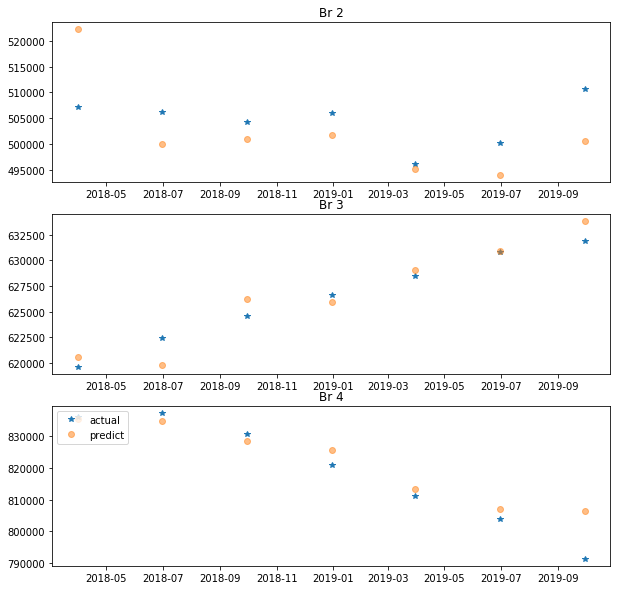

In [178]:
#Plot out-of-sample forecast vs actual values
fig, axs = plt.subplots(3, 1, figsize=(10,10))
axs[0].plot(df_house_test.br2, '*', label = 'actual')
axs[0].plot(df_fc_static.br2, 'o', alpha = 0.5, label = 'predict')
axs[0].set_title('Br 2')

axs[1].plot(df_house_test.br3, '*', label = 'actual')
axs[1].plot(df_fc_static.br3, 'o', alpha = 0.5, label = 'predict')
axs[1].set_title('Br 3')

axs[2].plot(df_house_test.br4, '*', label = 'actual')
axs[2].plot(df_fc_static.br4, 'o', alpha = 0.5, label = 'predict')
axs[2].set_title('Br 4')
plt.legend(loc="upper left")

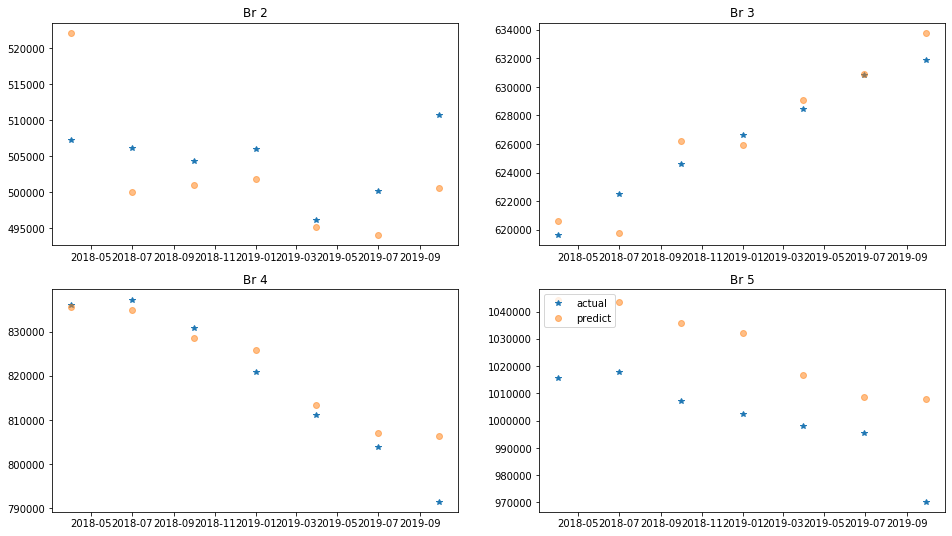

In [179]:
fig, axs = plt.subplots(2, 2, figsize=(16,9))
axs[0, 0].plot(df_test.br2, '*', label = 'actual')
axs[0, 0].plot(df_fc_static.br2, 'o', alpha = 0.5, label = 'predict')
axs[0, 0].set_title('Br 2')

axs[0, 1].plot(df_test.br3, '*', label = 'actual')
axs[0, 1].plot(df_fc_static.br3, 'o', alpha = 0.5, label = 'predict')
axs[0, 1].set_title('Br 3')

axs[1, 0].plot(df_test.br4, '*', label = 'actual')
axs[1, 0].plot(df_fc_static.br4, 'o', alpha = 0.5, label = 'predict')
axs[1, 0].set_title('Br 4')

axs[1, 1].plot(df_test.br5, '*', label = 'actual')
axs[1, 1].plot(df_fc_static.br5, 'o', alpha = 0.5, label = 'predict')
axs[1, 1].set_title('Br 5')

plt.legend(loc="upper left")
plt.savefig('fig6.png')

In [648]:
forecast_accuracy(df_fc_static, df_test)

{'MAPE': br2    1.290324
 br3    0.195660
 br4    0.536427
 br5    2.617599
 dtype: float64,
 'ME': br2    -2270.255382
 br3      276.268149
 br4     2887.050825
 br5    26163.456389
 dtype: float64,
 'MAE': br2     6533.132013
 br3     1223.867052
 br4     4322.570593
 br5    26163.456389
 dtype: float64,
 'MPE': br2   -0.004499
 br3    0.000436
 br4    0.003644
 br5    0.026176
 dtype: float64,
 'RMSE': br2     7821.818966
 br3     1471.381175
 br4     6231.537788
 br5    27179.766046
 dtype: float64}

In [53]:
#GET ERRORS FOR INDIVIDUAL HOUSES
data_raw = pd.read_csv('raw_sales.csv')

In [54]:
data_raw.head()

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3


In [55]:
data_raw.shape

(29580, 5)

In [56]:
df_house_raw =data_raw[data_raw.propertyType=='house'] #Let's limit the scope of this problem to houses only
df_house_raw['datesold'] = pd.to_datetime(df_house_raw['datesold'])
df_house_raw=df_house_raw.drop(columns=['postcode', 'propertyType'])
df_house_raw.head()

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,datesold,price,bedrooms
0,2007-02-07,525000,4
1,2007-02-27,290000,3
2,2007-03-07,328000,3
3,2007-03-09,380000,4
4,2007-03-21,310000,3


In [57]:
mask = (df_house_raw['datesold'] >  '2017-12-29')
df_raw_test = df_house_raw.loc[mask]

In [58]:
df_raw_test

,datesold,price,bedrooms
20666,2018-01-03,1200000,4
20667,2018-01-05,850000,4
20668,2018-01-05,980000,5
20669,2018-01-08,330000,2
20670,2018-01-08,485000,3
...,...,...,...
24547,2019-07-26,610000,3
24548,2019-07-26,657500,4
24549,2019-07-27,610000,4
24550,2019-07-27,647500,4


In [180]:
#BED2
df_raw_test2 = df_raw_test.loc[df_raw_test['bedrooms'] == 2]
df_raw_test2['predict'] = df_raw_test2['price']

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [181]:
df_raw_test2

,datesold,price,bedrooms,dynamic,predict
20669,2018-01-08,330000,2,522168.068207,330000
20672,2018-01-08,495000,2,522168.068207,495000
20687,2018-01-12,405000,2,522168.068207,405000
20698,2018-01-17,388000,2,522168.068207,388000
20699,2018-01-17,407500,2,522168.068207,407500
...,...,...,...,...,...
24480,2019-07-16,425000,2,548040.997271,425000
24505,2019-07-19,485000,2,548040.997271,485000
24524,2019-07-22,647000,2,548040.997271,647000
24528,2019-07-23,435000,2,548040.997271,435000


In [182]:
df_raw_test2.loc[df_raw_test2['datesold'] <=  '2018-03-31', 'predict'] = df_fc_static.br2[0]
df_raw_test2.loc[(df_raw_test2['datesold'] > '2018-03-31') & (df_raw_test2['datesold'] <=  '2018-06-30'), 'predict'] = df_fc_static.br2[1]
df_raw_test2.loc[(df_raw_test2['datesold'] > '2018-06-30') & (df_raw_test2['datesold'] <=  '2018-09-30'), 'predict'] = df_fc_static.br2[2]
df_raw_test2.loc[(df_raw_test2['datesold'] > '2018-09-30') & (df_raw_test2['datesold'] <=  '2018-12-31'), 'predict'] = df_fc_static.br2[3]
df_raw_test2.loc[(df_raw_test2['datesold'] > '2018-12-31') & (df_raw_test2['datesold'] <=  '2019-03-31'), 'predict'] = df_fc_static.br2[4]
df_raw_test2.loc[(df_raw_test2['datesold'] > '2019-03-31') & (df_raw_test2['datesold'] <=  '2019-06-30'), 'predict'] = df_fc_static.br2[5]
df_raw_test2.loc[(df_raw_test2['datesold'] >  '2019-06-30'), 'predict'] = df_fc_static.br2[6]

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [183]:
forecast_accuracy(df_raw_test2.predict, df_raw_test2.price)

{'MAPE': 27.928227644249077,
 'ME': -8255.588060124091,
 'MAE': 140769.47407386833,
 'MPE': 0.10067535582224954,
 'RMSE': 192287.4032644875}

In [184]:
#BED3
df_raw_test3 = df_raw_test.loc[df_raw_test['bedrooms'] == 3]
df_raw_test3['predict'] = df_raw_test3['price']
df_raw_test3

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,datesold,price,bedrooms,dynamic,predict
20670,2018-01-08,485000,3,620600.525220,485000
20671,2018-01-08,488255,3,620600.525220,488255
20674,2018-01-08,660000,3,620600.525220,660000
20675,2018-01-08,775000,3,620600.525220,775000
20678,2018-01-09,510000,3,620600.525220,510000
...,...,...,...,...,...
24541,2019-07-25,628000,3,637432.129184,628000
24542,2019-07-25,731000,3,637432.129184,731000
24545,2019-07-25,1130000,3,637432.129184,1130000
24546,2019-07-26,470000,3,637432.129184,470000


In [185]:
df_raw_test3.loc[df_raw_test3['datesold'] <=  '2018-03-31', 'predict'] = df_fc_static.br3[0]
df_raw_test3.loc[(df_raw_test3['datesold'] > '2018-03-31') & (df_raw_test3['datesold'] <=  '2018-06-30'), 'predict'] = df_fc_static.br3[1]
df_raw_test3.loc[(df_raw_test3['datesold'] > '2018-06-30') & (df_raw_test3['datesold'] <=  '2018-09-30'), 'predict'] = df_fc_static.br3[2]
df_raw_test3.loc[(df_raw_test3['datesold'] > '2018-09-30') & (df_raw_test3['datesold'] <=  '2018-12-31'), 'predict'] = df_fc_static.br3[3]
df_raw_test3.loc[(df_raw_test3['datesold'] > '2018-12-31') & (df_raw_test3['datesold'] <=  '2019-03-31'), 'predict'] = df_fc_static.br3[4]
df_raw_test3.loc[(df_raw_test3['datesold'] > '2019-03-31') & (df_raw_test3['datesold'] <=  '2019-06-30'), 'predict'] = df_fc_static.br3[5]
df_raw_test3.loc[(df_raw_test3['datesold'] >  '2019-06-30'), 'predict'] = df_fc_static.br3[6]

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [186]:
forecast_accuracy(df_raw_test3.predict, df_raw_test3.price)

{'MAPE': 20.136655384558164,
 'ME': -2004.1162221209324,
 'MAE': 132152.43831650034,
 'MPE': 0.06661998616025369,
 'RMSE': 203258.29089150883}

In [187]:
#BED4
df_raw_test4 = df_raw_test.loc[df_raw_test['bedrooms'] == 4]
df_raw_test4['predict'] = df_raw_test4['price']
df_raw_test4.loc[df_raw_test4['datesold'] <=  '2018-03-31', 'predict'] = df_fc_static.br4[0]
df_raw_test4.loc[(df_raw_test4['datesold'] > '2018-03-31') & (df_raw_test4['datesold'] <=  '2018-06-30'), 'predict'] = df_fc_static.br4[1]
df_raw_test4.loc[(df_raw_test4['datesold'] > '2018-06-30') & (df_raw_test4['datesold'] <=  '2018-09-30'), 'predict'] = df_fc_static.br4[2]
df_raw_test4.loc[(df_raw_test4['datesold'] > '2018-09-30') & (df_raw_test4['datesold'] <=  '2018-12-31'), 'predict'] = df_fc_static.br4[3]
df_raw_test4.loc[(df_raw_test4['datesold'] > '2018-12-31') & (df_raw_test4['datesold'] <=  '2019-03-31'), 'predict'] = df_fc_static.br4[4]
df_raw_test4.loc[(df_raw_test4['datesold'] > '2019-03-31') & (df_raw_test4['datesold'] <=  '2019-06-30'), 'predict'] = df_fc_static.br4[5]
df_raw_test4.loc[(df_raw_test4['datesold'] >  '2019-06-30'), 'predict'] = df_fc_static.br4[6]
df_raw_test4

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,datesold,price,bedrooms,dynamic,predict
20666,2018-01-03,1200000,4,835533.776827,835533.776827073
20667,2018-01-05,850000,4,835533.776827,835533.776827073
20673,2018-01-08,545000,4,835533.776827,835533.776827073
20676,2018-01-08,820000,4,835533.776827,835533.776827073
20677,2018-01-08,850000,4,835533.776827,835533.776827073
...,...,...,...,...,...
24543,2019-07-25,790000,4,841548.439498,806358.396644375
24544,2019-07-25,792000,4,841548.439498,806358.396644375
24548,2019-07-26,657500,4,841548.439498,806358.396644375
24549,2019-07-27,610000,4,841548.439498,806358.396644375


In [188]:
forecast_accuracy(df_raw_test4.predict, df_raw_test4.price)

{'MAPE': 22.550497690894925,
 'ME': 8636.099670559559,
 'MAE': 177253.00963184424,
 'MPE': 0.0989952999835196,
 'RMSE': 264006.92649579985}

In [189]:
#BED5
df_raw_test5 = df_raw_test.loc[df_raw_test['bedrooms'] == 5]
df_raw_test5['predict'] = df_raw_test5['price']
df_raw_test5.loc[df_raw_test5['datesold'] <=  '2018-03-31', 'predict'] = df_fc_static.br5[0]
df_raw_test5.loc[(df_raw_test5['datesold'] > '2018-03-31') & (df_raw_test5['datesold'] <=  '2018-06-30'), 'predict'] = df_fc_static.br5[1]
df_raw_test5.loc[(df_raw_test5['datesold'] > '2018-06-30') & (df_raw_test5['datesold'] <=  '2018-09-30'), 'predict'] = df_fc_static.br5[2]
df_raw_test5.loc[(df_raw_test5['datesold'] > '2018-09-30') & (df_raw_test5['datesold'] <=  '2018-12-31'), 'predict'] = df_fc_static.br5[3]
df_raw_test5.loc[(df_raw_test5['datesold'] > '2018-12-31') & (df_raw_test5['datesold'] <=  '2019-03-31'), 'predict'] = df_fc_static.br5[4]
df_raw_test5.loc[(df_raw_test5['datesold'] > '2019-03-31') & (df_raw_test5['datesold'] <=  '2019-06-30'), 'predict'] = df_fc_static.br5[5]
df_raw_test5.loc[(df_raw_test5['datesold'] >  '2019-06-30'), 'predict'] = df_fc_static.br5[6]
df_raw_test5

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,datesold,price,bedrooms,dynamic,predict
20668,2018-01-05,980000,5,1.044417e+06,1044417.22103384
20695,2018-01-15,937000,5,1.044417e+06,1044417.22103384
20704,2018-01-17,730000,5,1.044417e+06,1044417.22103384
20711,2018-01-18,1570000,5,1.044417e+06,1044417.22103384
20738,2018-01-24,941000,5,1.044417e+06,1044417.22103384
...,...,...,...,...,...
24479,2019-07-15,877000,5,1.051936e+06,1007947.99580547
24510,2019-07-19,710000,5,1.051936e+06,1007947.99580547
24512,2019-07-19,1150000,5,1.051936e+06,1007947.99580547
24532,2019-07-23,700000,5,1.051936e+06,1007947.99580547


In [190]:
forecast_accuracy(df_raw_test5.predict, df_raw_test5.price)

{'MAPE': 27.373754409666674,
 'ME': 37069.50348244862,
 'MAE': 271745.56329826906,
 'MPE': 0.14393839423512583,
 'RMSE': 417374.0772563952}

In [191]:
#BR 1-5
df_raw_test2345 = df_raw_test.loc[df_raw_test['bedrooms'] != 1]
df_raw_test2345['predict'] = df_raw_test2345['price']
df_raw_test2345

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,datesold,price,bedrooms,dynamic,predict
20666,2018-01-03,1200000,4,8.355338e+05,1200000
20667,2018-01-05,850000,4,8.355338e+05,850000
20668,2018-01-05,980000,5,1.044417e+06,980000
20669,2018-01-08,330000,2,5.221681e+05,330000
20670,2018-01-08,485000,3,6.206005e+05,485000
...,...,...,...,...,...
24547,2019-07-26,610000,3,6.374321e+05,610000
24548,2019-07-26,657500,4,8.415484e+05,657500
24549,2019-07-27,610000,4,8.415484e+05,610000
24550,2019-07-27,647500,4,8.415484e+05,647500


In [192]:
df_raw_test2345.loc[df_raw_test2345['bedrooms'] ==  2, 'predict'] = df_raw_test2.predict
df_raw_test2345.loc[df_raw_test2345['bedrooms'] ==  3, 'predict'] = df_raw_test3.predict
df_raw_test2345.loc[df_raw_test2345['bedrooms'] ==  4, 'predict'] = df_raw_test4.predict
df_raw_test2345.loc[df_raw_test2345['bedrooms'] ==  5, 'predict'] = df_raw_test5.predict

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [193]:
df_raw_test2345

,datesold,price,bedrooms,dynamic,predict
20666,2018-01-03,1200000,4,8.355338e+05,835533.776827073
20667,2018-01-05,850000,4,8.355338e+05,835533.776827073
20668,2018-01-05,980000,5,1.044417e+06,1044417.22103384
20669,2018-01-08,330000,2,5.221681e+05,522168.068207032
20670,2018-01-08,485000,3,6.206005e+05,620600.525219514
...,...,...,...,...,...
24547,2019-07-26,610000,3,6.374321e+05,633796.126035404
24548,2019-07-26,657500,4,8.415484e+05,806358.396644375
24549,2019-07-27,610000,4,8.415484e+05,806358.396644375
24550,2019-07-27,647500,4,8.415484e+05,806358.396644375


In [194]:
forecast_accuracy(df_raw_test2345.predict, df_raw_test2345.price)

{'MAPE': 22.114221214044537,
 'ME': 5845.980365149679,
 'MAE': 164399.93829078102,
 'MPE': 0.08875405356125918,
 'RMSE': 255504.24054320107}

In [195]:
df_raw_test234 = df_raw_test2345.loc[df_raw_test2345['bedrooms'] != 5]
df_raw_test234

,datesold,price,bedrooms,dynamic,predict
20666,2018-01-03,1200000,4,835533.776827,835533.776827073
20667,2018-01-05,850000,4,835533.776827,835533.776827073
20669,2018-01-08,330000,2,522168.068207,522168.068207032
20670,2018-01-08,485000,3,620600.525220,620600.525219514
20671,2018-01-08,488255,3,620600.525220,620600.525219514
...,...,...,...,...,...
24546,2019-07-26,470000,3,637432.129184,633796.126035404
24547,2019-07-26,610000,3,637432.129184,633796.126035404
24548,2019-07-26,657500,4,841548.439498,806358.396644375
24549,2019-07-27,610000,4,841548.439498,806358.396644375


In [196]:
forecast_accuracy(df_raw_test234.predict, df_raw_test234.price)

{'MAPE': 21.596474258333643,
 'ME': 2772.345607219796,
 'MAE': 153832.86541770177,
 'MPE': 0.08332172272045585,
 'RMSE': 233581.87144730389}

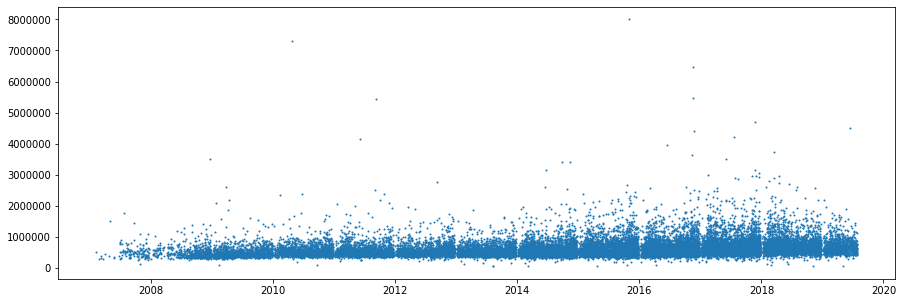

In [664]:
%matplotlib inline 
plt.figure(figsize=(15,5))
plt.plot_date(df_raw['datesold'], df_raw['price'], xdate=True, markersize=1)

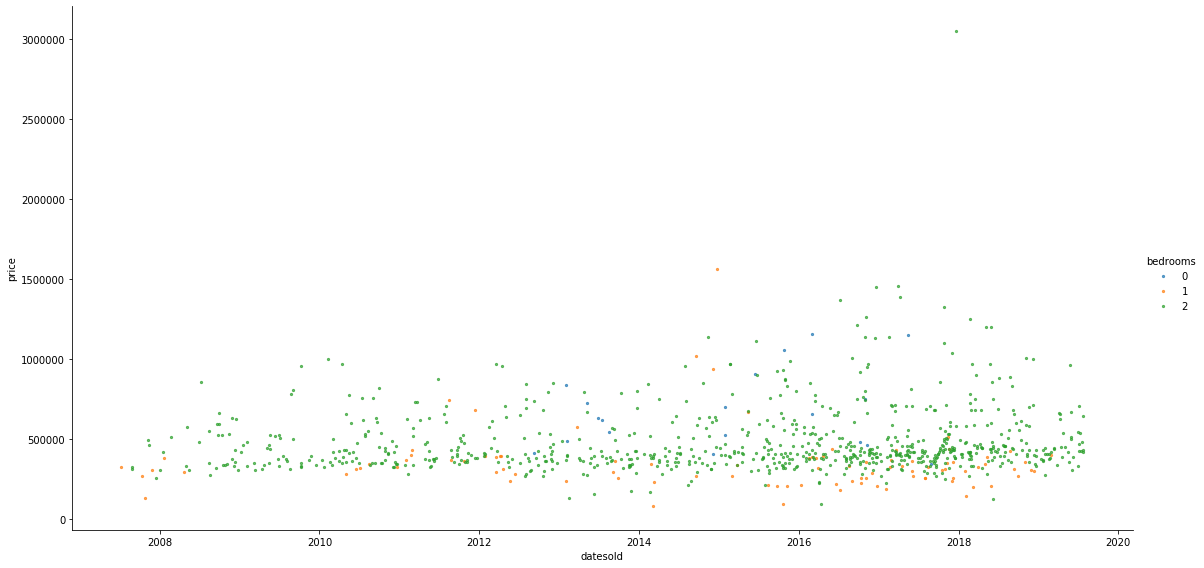

In [669]:
import seaborn
from  matplotlib import pyplot
df_raw1=df_raw[df_raw.bedrooms<3]
_bedrooms=df_raw1['bedrooms'].unique().sort()
fg = seaborn.FacetGrid(data=df_raw1, hue='bedrooms', hue_order=_bedrooms, aspect=2, height=8)
fg.map(pyplot.scatter, 'datesold', 'price', alpha=.7, s=5).add_legend()

In [202]:
#UNITS
#Let's limit the scope of this problem to houses only
df_unit = df[df.type=='unit'] 
df_unit['saledate'] = pd.to_datetime(df_unit['saledate'])
df_unit.head()

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,saledate,MA,type,bedrooms
200,2007-12-31,326076,unit,1
201,2008-03-31,326076,unit,1
202,2008-06-30,326076,unit,1
203,2008-09-30,326076,unit,1
204,2008-12-31,327321,unit,1


In [203]:
#group by number of bedroom
df_unit = pd.pivot_table(df_unit, values = 'MA', index='saledate', columns = 'bedrooms')
df_unit.head()

bedrooms,1,2,3
saledate,,,
2007-06-30,NaN,368817.0,NaN
2007-09-30,NaN,368817.0,518911.0
2007-12-31,326076.0,368817.0,518911.0
2008-03-31,326076.0,368817.0,518911.0
2008-06-30,326076.0,373482.0,518911.0


In [204]:
#check NA value
df_unit.isnull().sum().sum()

3

In [205]:
#exclude the first 2 observations
df_unit = df_unit.loc['2007-12-30':]
df_unit = pd.DataFrame(df_unit.to_records())
df_unit = df_unit.set_index(pd.DatetimeIndex(df_unit['saledate']))

del df_unit['saledate']
df_unit.columns = ['br1','br2', 'br3']
df_unit.head()


,br1,br2,br3
saledate,,,
2007-12-31,326076.0,368817.0,518911.0
2008-03-31,326076.0,368817.0,518911.0
2008-06-30,326076.0,373482.0,518911.0
2008-09-30,326076.0,377481.0,518911.0
2008-12-31,327321.0,382010.0,518911.0


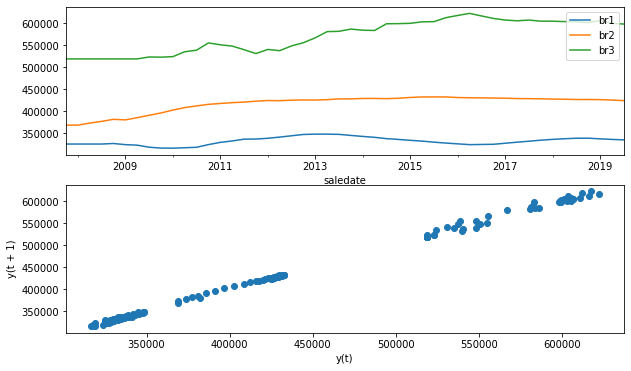

In [206]:
#plot data
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,6))
df_unit.plot(ax=ax1)
pd.plotting.lag_plot(df_unit)
plt.show()

In [207]:
#split dataset
df_unit_train = df_unit.loc[:'2017-12-31']
df_unit_test = df_unit.loc['2018-03-31':]

In [208]:
#test stationary, if p-value < 0.05 stationary
print('Augmented Dickey-Fuller Test: Bedroom 1 Time Series')
augmented_dickey_fuller_statistics(df_unit_train['br1'])
print('Augmented Dickey-Fuller Test: Bedroom 3 Time Series')
augmented_dickey_fuller_statistics(df_unit_train['br2'])
print('Augmented Dickey-Fuller Test: Bedroom 4 Time Series')
augmented_dickey_fuller_statistics(df_unit_train['br3'])

Augmented Dickey-Fuller Test: Bedroom 1 Time Series
ADF Statistic: -2.860433
p-value: 0.050146
Critical Values:
	1%: -3.639
	5%: -2.951
	10%: -2.614
Augmented Dickey-Fuller Test: Bedroom 3 Time Series
ADF Statistic: -4.497289
p-value: 0.000199
Critical Values:
	1%: -3.610
	5%: -2.939
	10%: -2.608
Augmented Dickey-Fuller Test: Bedroom 4 Time Series
ADF Statistic: -0.974927
p-value: 0.762299
Critical Values:
	1%: -3.639
	5%: -2.951
	10%: -2.614


In [209]:
# taking log and 1st difference
df_unit_log = np.log(df_unit_train)
df_unit_diff1 = df_unit_log.diff().dropna()
#chech stationary of 1st differenced data
print('Augmented Dickey-Fuller Test: Bedroom 1 Time Series')
augmented_dickey_fuller_statistics(df_unit_diff1['br1'])
print('Augmented Dickey-Fuller Test: Bedroom 3 Time Series')
augmented_dickey_fuller_statistics(df_unit_diff1['br2'])
print('Augmented Dickey-Fuller Test: Bedroom 4 Time Series')
augmented_dickey_fuller_statistics(df_unit_diff1['br3'])

Augmented Dickey-Fuller Test: Bedroom 1 Time Series
ADF Statistic: -2.571579
p-value: 0.099015
Critical Values:
	1%: -3.627
	5%: -2.946
	10%: -2.612
Augmented Dickey-Fuller Test: Bedroom 3 Time Series
ADF Statistic: -1.595998
p-value: 0.485604
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610
Augmented Dickey-Fuller Test: Bedroom 4 Time Series
ADF Statistic: -2.767417
p-value: 0.063081
Critical Values:
	1%: -3.639
	5%: -2.951
	10%: -2.614


In [210]:
# take 2nd difference
df_unit_diff2 = df_unit_diff1.diff().dropna()
print('Augmented Dickey-Fuller Test: Bedroom 1 Time Series')
augmented_dickey_fuller_statistics(df_unit_diff2['br1'])
print('Augmented Dickey-Fuller Test: Bedroom 3 Time Series')
augmented_dickey_fuller_statistics(df_unit_diff2['br2'])
print('Augmented Dickey-Fuller Test: Bedroom 4 Time Series')
augmented_dickey_fuller_statistics(df_unit_diff2['br3'])

Augmented Dickey-Fuller Test: Bedroom 1 Time Series
ADF Statistic: -3.287656
p-value: 0.015439
Critical Values:
	1%: -3.633
	5%: -2.949
	10%: -2.613
Augmented Dickey-Fuller Test: Bedroom 3 Time Series
ADF Statistic: -10.066746
p-value: 0.000000
Critical Values:
	1%: -3.616
	5%: -2.941
	10%: -2.609
Augmented Dickey-Fuller Test: Bedroom 4 Time Series
ADF Statistic: -4.004540
p-value: 0.001387
Critical Values:
	1%: -3.670
	5%: -2.964
	10%: -2.621


In [211]:
#Initiate VAR model
model = VAR(df_unit_diff2)
res = model.select_order(8)
res.summary()

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


,AIC,BIC,FPE,HQIC
0,-31.10,-30.96*,3.126e-14,-31.05
1,-31.29,-30.74,2.578e-14,-31.11
2,-31.02,-30.05,3.463e-14,-30.70
3,-31.20,-29.81,3.031e-14,-30.75
4,-31.39,-29.58,2.756e-14,-30.80
5,-31.60,-29.38,2.638e-14,-30.87
6,-32.39,-29.75,1.576e-14,-31.53
7,-33.13,-30.08,1.180e-14,-32.14
8,-34.04*,-30.57,1.057e-14*,-32.91*


In [212]:
#choose model with smallest AIC
model_fitted = model.fit(8)
#model_fitted.summary()

In [213]:
#convert back to original data after 2nd difference
def invert_transformation2 (forecast, df_diff1, df_log): 
    df_diff1_fc = forecast + df_diff1.shift()
    df_log_fc = df_diff1_fc + df_log.shift()
    df_fc = np.exp(df_log_fc)
    return df_fc

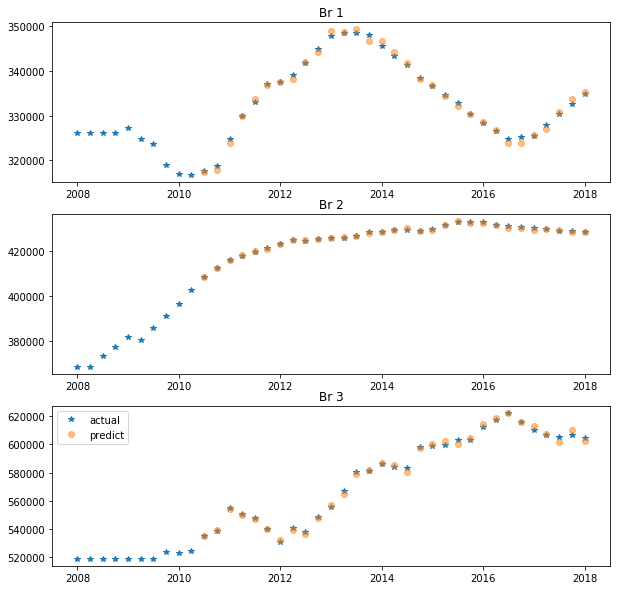

In [214]:
data_fitted = invert_transformation2 (model_fitted.fittedvalues, df_unit_diff1, df_unit_log)
#Plot in-sample fit vs actual values
fig, axs = plt.subplots(3, 1, figsize=(10,10))
axs[0].plot(df_unit_train.br1, '*', label = 'actual')
axs[0].plot(data_fitted.br1, 'o', alpha = 0.5, label = 'predict')
axs[0].set_title('Br 1')

axs[1].plot(df_unit_train.br2, '*', label = 'actual')
axs[1].plot(data_fitted.br2, 'o', alpha = 0.5, label = 'predict')
axs[1].set_title('Br 2')

axs[2].plot(df_unit_train.br3, '*', label = 'actual')
axs[2].plot(data_fitted.br3, 'o', alpha = 0.5, label = 'predict')
axs[2].set_title('Br 3')
plt.legend(loc="upper left")

In [226]:
params = model_fitted.params

In [228]:
params.head()

,br1,br2,br3
const,0.001785,-0.001095,-0.002829
L1.br1,0.172835,-0.384666,-0.224315
L1.br2,0.838548,-0.303605,-1.015744
L1.br3,0.026067,-0.051494,-0.466620
L2.br1,0.489475,0.154597,-0.034919


In [233]:
params.columns = ['br2', 'br3', 'br4']
params.head()

,br2,br3,br4
const,0.001785,-0.001095,-0.002829
L1.br1,0.172835,-0.384666,-0.224315
L1.br2,0.838548,-0.303605,-1.015744
L1.br3,0.026067,-0.051494,-0.466620
L2.br1,0.489475,0.154597,-0.034919


In [216]:
df_log = np.log(df_unit)
df_diff1 = df_log.diff().dropna()
df_diff2 = df_diff1.diff().dropna()

In [314]:
ls_br1 = []
expr_br2 = params.br2[0] + params.br2[1]*l1_br2 + params.br2[2]*l1_br3 + params.br2[3]*l1_br4 + params.br2[4]*l2_br2 + params.br2[5]*l2_br3 + params.br2[6]*l2_br4 + params.br2[7]*l3_br2 + params.br2[8]*l3_br3 + params.br2[9]*l3_br4 + params.br2[10]*l4_br2 + params.br2[11]*l4_br3 + params.br2[12]*l4_br4 + params.br2[13]*l5_br2 + params.br2[14]*l5_br3 + params.br2[15]*l5_br4 + params.br2[16]*l6_br2 + params.br2[17]*l6_br3 + params.br2[18]*l6_br4 + params.br2[19]*l7_br2 + params.br2[20]*l7_br3 + params.br2[21]*l7_br4 + params.br2[22]*l8_br2 + params.br2[23]*l8_br3 + params.br2[24]*l8_br4

for l1_br2_sub, l1_br3_sub, l1_br4_sub, l2_br2_sub, l2_br3_sub, l2_br4_sub, l3_br2_sub, l3_br3_sub, l3_br4_sub, l4_br2_sub, l4_br3_sub, l4_br4_sub,l5_br2_sub, l5_br3_sub, l5_br4_sub, l6_br2_sub, l6_br3_sub, l6_br4_sub, l7_br2_sub, l7_br3_sub, l7_br4_sub, l8_br2_sub, l8_br3_sub, l8_br4_sub in zip(df_diff2.br1[-8:-1], df_diff2.br2[-8:-1], df_diff2.br3[-8:-1],df_diff2.br1[-9:-2], df_diff3.br2[-9:-2], df_diff3.br3[-9:-2],df_diff2.br1[-10:-3], df_diff2.br2[-10:-3], df_diff2.br3[-10:-3],df_diff2.br1[-11:-4], df_diff2.br2[-11:-4], df_diff2.br3[-11:-4],df_diff2.br1[-12:-5], df_diff2.br2[-12:-5], df_diff2.br3[-12:-5],df_diff2.br1[-13:-6], df_diff2.br2[-13:-6], df_diff2.br3[-13:-6],df_diff2.br1[-14:-7], df_diff2.br2[-14:-7], df_diff2.br3[-14:-7],df_diff2.br1[-15:-8], df_diff2.br2[-15:-8], df_diff2.br3[-15:-8]):
    expr2 = expr_br2.subs(l1_br2, l1_br2_sub).subs(l1_br3, l1_br3_sub).subs(l1_br4, l1_br4_sub).subs(l2_br2, l2_br2_sub).subs(l2_br3, l2_br3_sub).subs(l2_br4, l2_br4_sub).subs(l3_br2, l3_br2_sub).subs(l3_br3, l3_br3_sub).subs(l3_br4, l3_br4_sub).subs(l4_br2, l4_br2_sub).subs(l4_br3, l4_br3_sub).subs(l4_br4, l4_br4_sub).subs(l5_br2, l5_br2_sub).subs(l5_br3, l5_br3_sub).subs(l5_br4, l5_br4_sub).subs(l6_br2, l6_br2_sub).subs(l6_br3, l6_br3_sub).subs(l6_br4, l6_br4_sub).subs(l7_br2, l7_br2_sub).subs(l7_br3, l7_br3_sub).subs(l7_br4, l7_br4_sub).subs(l8_br2, l8_br2_sub).subs(l8_br3, l8_br3_sub).subs(l8_br4, l8_br4_sub)
    ls_br1.append(expr2.evalf())

In [315]:
ls_br1

[0.00104446278489406,
 -0.00250289675535215,
 0.00831083899811725,
 0.00245192056348292,
 0.00566361550754248,
 0.00198222308027427,
 -0.0171597795038832]

In [267]:
ls_br2 = []
expr_br3 = params.br3[0] + params.br3[1]*l1_br2 + params.br3[2]*l1_br3 + params.br3[3]*l1_br4 + params.br3[4]*l2_br2 + params.br3[5]*l2_br3 + params.br3[6]*l2_br4 + params.br3[7]*l3_br2 + params.br3[8]*l3_br3 + params.br3[9]*l3_br4 + params.br3[10]*l4_br2 + params.br3[11]*l4_br3 + params.br3[12]*l4_br4 + params.br3[13]*l5_br2 + params.br3[14]*l5_br3 + params.br3[15]*l5_br4 + params.br3[16]*l6_br2 + params.br3[17]*l6_br3 + params.br3[18]*l6_br4 + params.br3[19]*l7_br2 + params.br3[20]*l7_br3 + params.br3[21]*l7_br4 + params.br3[22]*l8_br2 + params.br3[23]*l8_br3 + params.br3[24]*l8_br4

for l1_br2_sub, l1_br3_sub, l1_br4_sub, l2_br2_sub, l2_br3_sub, l2_br4_sub, l3_br2_sub, l3_br3_sub, l3_br4_sub, l4_br2_sub, l4_br3_sub, l4_br4_sub,l5_br2_sub, l5_br3_sub, l5_br4_sub, l6_br2_sub, l6_br3_sub, l6_br4_sub, l7_br2_sub, l7_br3_sub, l7_br4_sub, l8_br2_sub, l8_br3_sub, l8_br4_sub in zip(df_diff2.br1[-8:-1], df_diff2.br2[-8:-1], 
df_diff2.br3[-8:-1],df_diff2.br1[-9:-2], df_diff3.br2[-9:-2], df_diff3.br3[-9:-2],
df_diff2.br1[-10:-3], df_diff2.br2[-10:-3], df_diff2.br3[-10:-3],
df_diff2.br1[-11:-4], df_diff2.br2[-11:-4], df_diff2.br3[-11:-4],
df_diff2.br1[-12:-5], df_diff2.br2[-12:-5], df_diff2.br3[-12:-5],
df_diff2.br1[-13:-6], df_diff2.br2[-13:-6], df_diff2.br3[-13:-6],
df_diff2.br1[-14:-7], df_diff2.br2[-14:-7], df_diff2.br3[-14:-7],
df_diff2.br1[-15:-8], df_diff2.br2[-15:-8], df_diff2.br3[-15:-8]):
    expr3 = expr_br3.subs(l1_br2, l1_br2_sub).subs(l1_br3, l1_br3_sub).subs(l1_br4, l1_br4_sub).subs(l2_br2, l2_br2_sub).subs(l2_br3, l2_br3_sub).subs(l2_br4, l2_br4_sub).subs(l3_br2, l3_br2_sub).subs(l3_br3, l3_br3_sub).subs(l3_br4, l3_br4_sub).subs(l4_br2, l4_br2_sub).subs(l4_br3, l4_br3_sub).subs(l4_br4, l4_br4_sub).subs(l5_br2, l5_br2_sub).subs(l5_br3, l5_br3_sub).subs(l5_br4, l5_br4_sub).subs(l6_br2, l6_br2_sub).subs(l6_br3, l6_br3_sub).subs(l6_br4, l6_br4_sub).subs(l7_br2, l7_br2_sub).subs(l7_br3, l7_br3_sub).subs(l7_br4, l7_br4_sub).subs(l8_br2, l8_br2_sub).subs(l8_br3, l8_br3_sub).subs(l8_br4, l8_br4_sub)
    ls_br2.append(expr3.evalf())

In [268]:
ls_br2

[-0.00381398332164665,
 -0.00493842395348542,
 -0.00462298988580251,
 -0.00170573192075987,
 0.00181312911796494,
 0.00153895817228125,
 -0.00399999978878747]

In [269]:
ls_br3 = []
expr_br4 = params.br4[0] + params.br4[1]*l1_br2 + params.br4[2]*l1_br3 + params.br4[3]*l1_br4 + params.br4[4]*l2_br2 + params.br4[5]*l2_br3 + params.br4[6]*l2_br4 + params.br4[7]*l3_br2 + params.br4[8]*l3_br3 + params.br4[9]*l3_br4 + params.br4[10]*l4_br2 + params.br4[11]*l4_br3 + params.br4[12]*l4_br4 + params.br4[13]*l5_br2 + params.br4[14]*l5_br3 + params.br4[15]*l5_br4 + params.br4[16]*l6_br2 + params.br4[17]*l6_br3 + params.br4[18]*l6_br4 + params.br4[19]*l7_br2 + params.br4[20]*l7_br3 + params.br4[21]*l7_br4 + params.br4[22]*l8_br2 + params.br4[23]*l8_br3 + params.br4[24]*l8_br4

for l1_br2_sub, l1_br3_sub, l1_br4_sub, l2_br2_sub, l2_br3_sub, l2_br4_sub, l3_br2_sub, l3_br3_sub, l3_br4_sub, l4_br2_sub, l4_br3_sub, l4_br4_sub,l5_br2_sub, l5_br3_sub, l5_br4_sub, l6_br2_sub, l6_br3_sub, l6_br4_sub, l7_br2_sub, l7_br3_sub, l7_br4_sub, l8_br2_sub, l8_br3_sub, l8_br4_sub in zip(df_diff2.br1[-8:-1], df_diff2.br2[-8:-1], 
df_diff2.br3[-8:-1],df_diff2.br1[-9:-2], df_diff3.br2[-9:-2], df_diff3.br3[-9:-2],
df_diff2.br1[-10:-3], df_diff2.br2[-10:-3], df_diff2.br3[-10:-3],
df_diff2.br1[-11:-4], df_diff2.br2[-11:-4], df_diff2.br3[-11:-4],
df_diff2.br1[-12:-5], df_diff2.br2[-12:-5], df_diff2.br3[-12:-5],
df_diff2.br1[-13:-6], df_diff2.br2[-13:-6], df_diff2.br3[-13:-6],
df_diff2.br1[-14:-7], df_diff2.br2[-14:-7], df_diff2.br3[-14:-7],
df_diff2.br1[-15:-8], df_diff2.br2[-15:-8], df_diff2.br3[-15:-8]):
    expr4 = expr_br4.subs(l1_br2, l1_br2_sub).subs(l1_br3, l1_br3_sub).subs(l1_br4, l1_br4_sub).subs(l2_br2, l2_br2_sub).subs(l2_br3, l2_br3_sub).subs(l2_br4, l2_br4_sub).subs(l3_br2, l3_br2_sub).subs(l3_br3, l3_br3_sub).subs(l3_br4, l3_br4_sub).subs(l4_br2, l4_br2_sub).subs(l4_br3, l4_br3_sub).subs(l4_br4, l4_br4_sub).subs(l5_br2, l5_br2_sub).subs(l5_br3, l5_br3_sub).subs(l5_br4, l5_br4_sub).subs(l6_br2, l6_br2_sub).subs(l6_br3, l6_br3_sub).subs(l6_br4, l6_br4_sub).subs(l7_br2, l7_br2_sub).subs(l7_br3, l7_br3_sub).subs(l7_br4, l7_br4_sub).subs(l8_br2, l8_br2_sub).subs(l8_br3, l8_br3_sub).subs(l8_br4, l8_br4_sub)
    ls_br3.append(expr4.evalf())

In [270]:
ls_br3

[0.00662714540409134,
 -0.00269720123386149,
 0.000830824730616577,
 -0.00194756971589040,
 -0.0108948736394830,
 -0.00928198113323819,
 0.0152266000167811]

In [271]:
diff_unit_fc_static = {'br1':ls_br1, 'br2':ls_br2, 'br3':ls_br3}
df_unit_fc_2d =  pd.DataFrame(diff_unit_fc_static, index = df_unit_test.index)
df_unit_fc_2d

,br1,br2,br3
saledate,,,
2018-03-31,0.00104446278489406,-0.00381398332164665,0.00662714540409134
2018-06-30,-0.00250289675535215,-0.00493842395348542,-0.00269720123386149
2018-09-30,0.00831083899811725,-0.00462298988580251,0.000830824730616577
2018-12-31,0.00245192056348292,-0.00170573192075987,-0.00194756971589040
2019-03-31,0.00566361550754248,0.00181312911796494,-0.0108948736394830
2019-06-30,0.00198222308027427,0.00153895817228125,-0.00928198113323819
2019-09-30,-0.0171597795038832,-0.00399999978878747,0.0152266000167811


In [272]:
def invert_transformation3 (forecast): 
    df_diff1_try = forecast + df_diff1.shift()
    df_log_try = df_diff1_try + df_log.shift()
    return df_log_try

In [273]:
#convert static
df_log_try = invert_transformation3 (df_unit_fc_2d)[-7:]
df_log_try

,br1,br2,br3
saledate,,,
2018-03-31,12.7293075981115,12.9634996281865,13.3146162590374
2018-06-30,12.7297174931968,12.9600248214103,13.3089186979464
2018-09-30,12.7437739157648,12.9608295313078,13.3098002690677
2018-12-31,12.7401484303044,12.9612350870680,13.3079372197600
2019-03-31,12.7408340763455,12.9661228931331,13.2922228461500
2019-06-30,12.7278384602048,12.9646771920245,13.3121621250766
2019-09-30,12.7055284043902,12.9550238546908,13.3083558448461


In [294]:
br1_static = []
br2_static = []
br3_static = []
for i,j,k in zip(df_log_try.br1.values, df_log_try.br2.values, df_log_try.br3.values):
    exp_br1 = exp(i)
    exp_br2 = exp(j)
    exp_br3 = exp(k)
    br1_static.append(exp_br1)
    br2_static.append(exp_br2)
    br3_static.append(exp_br3)

In [295]:
data_fc_static = {'br1':br1_static, 'br2':br2_static, 'br3':br3_static}
df_unit_fc_static =  pd.DataFrame(data_fc_static, index = df_unit_test.index)
df_unit_fc_static

,br1,br2,br3
saledate,,,
2018-03-31,337495.548005020,426556.294154116,605988.482464912
2018-06-30,337633.914127317,425076.665653090,602545.643272446
2018-09-30,342413.351297469,425418.866720984,603077.064319161
2018-12-31,341174.184319135,425591.432783088,601954.547988318
2019-03-31,341408.189261056,427676.733290126,592569.145323314
2019-06-30,337000.084543286,427058.887280663,604503.128924043
2019-09-30,329564.842577261,422956.178058285,602206.594015499


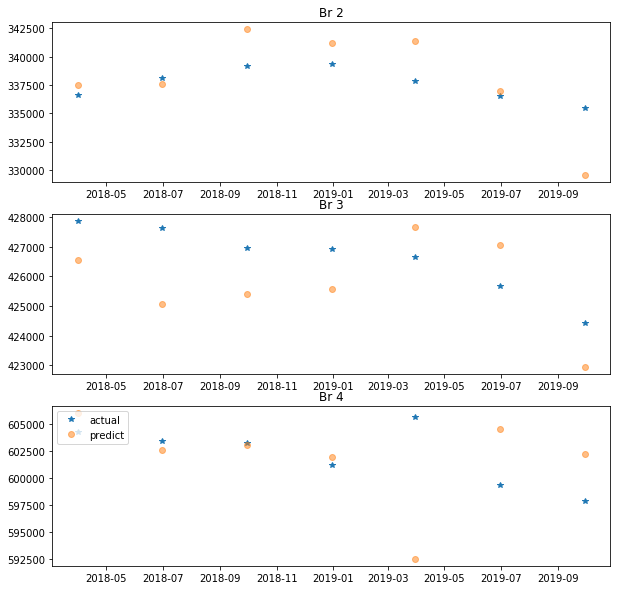

In [296]:
#Plot out-of-sample forecast vs actual values
fig, axs = plt.subplots(3, 1, figsize=(10,10))
axs[0].plot(df_unit_test.br1, '*', label = 'actual')
axs[0].plot(df_unit_fc_static.br1, 'o', alpha = 0.5, label = 'predict')
axs[0].set_title('Br 2')

axs[1].plot(df_unit_test.br2, '*', label = 'actual')
axs[1].plot(df_unit_fc_static.br2, 'o', alpha = 0.5, label = 'predict')
axs[1].set_title('Br 3')

axs[2].plot(df_unit_test.br3, '*', label = 'actual')
axs[2].plot(df_unit_fc_static.br3, 'o', alpha = 0.5, label = 'predict')
axs[2].set_title('Br 4')
plt.legend(loc="upper left")

In [297]:
df_unit_raw =data_raw[data_raw.propertyType=='unit'] #Let's limit the scope of this problem to houses only
df_unit_raw['datesold'] = pd.to_datetime(df_unit_raw['datesold'])
df_unit_raw=df_unit_raw.drop(columns=['postcode', 'propertyType'])
df_unit_raw.head()

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,datesold,price,bedrooms
24552,2007-06-27,300000,2
24553,2007-07-05,300000,2
24554,2007-07-19,480000,3
24555,2007-07-20,360000,2
24556,2007-08-07,385000,3


In [299]:
mask = (df_unit_raw['datesold'] >  '2017-12-29')
df_unit_raw_test = df_unit_raw.loc[mask]
df_unit_raw_test['predict'] = df_unit_raw_test['price']
df_unit_raw_test

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,datesold,price,bedrooms,predict
28223,2018-01-02,299000,1,299000
28224,2018-01-03,354900,1,354900
28225,2018-01-03,410000,1,410000
28226,2018-01-04,350000,2,350000
28227,2018-01-08,386000,1,386000
...,...,...,...,...
29575,2019-07-25,500000,3,500000
29576,2019-07-25,560000,2,560000
29577,2019-07-26,464950,2,464950
29578,2019-07-26,589000,2,589000


In [300]:
#BED1
df_raw_test1 = df_unit_raw_test.loc[df_unit_raw_test['bedrooms'] == 1]
df_raw_test1.loc[df_raw_test1['datesold'] <=  '2018-03-31', 'predict'] = df_unit_fc_static.br1[0]
df_raw_test1.loc[(df_raw_test1['datesold'] > '2018-03-31') & (df_raw_test1['datesold'] <=  '2018-06-30'), 'predict'] = df_unit_fc_static.br1[1]
df_raw_test1.loc[(df_raw_test1['datesold'] > '2018-06-30') & (df_raw_test1['datesold'] <=  '2018-09-30'), 'predict'] = df_unit_fc_static.br1[2]
df_raw_test1.loc[(df_raw_test1['datesold'] > '2018-09-30') & (df_raw_test1['datesold'] <=  '2018-12-31'), 'predict'] = df_unit_fc_static.br1[3]
df_raw_test1.loc[(df_raw_test1['datesold'] > '2018-12-31') & (df_raw_test1['datesold'] <=  '2019-03-31'), 'predict'] = df_unit_fc_static.br1[4]
df_raw_test1.loc[(df_raw_test1['datesold'] > '2019-03-31') & (df_raw_test1['datesold'] <=  '2019-06-30'), 'predict'] = df_unit_fc_static.br1[5]
df_raw_test1.loc[(df_raw_test1['datesold'] >  '2019-06-30'), 'predict'] = df_unit_fc_static.br1[6]
df_raw_test1

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,datesold,price,bedrooms,predict
28223,2018-01-02,299000,1,337495.548005020
28224,2018-01-03,354900,1,337495.548005020
28225,2018-01-03,410000,1,337495.548005020
28227,2018-01-08,386000,1,337495.548005020
28228,2018-01-09,295000,1,337495.548005020
...,...,...,...,...
29562,2019-07-23,310000,1,329564.842577261
29569,2019-07-24,590000,1,329564.842577261
29570,2019-07-25,172500,1,329564.842577261
29572,2019-07-25,321000,1,329564.842577261


In [301]:
#BED2
df_raw_test2 = df_unit_raw_test.loc[df_unit_raw_test['bedrooms'] == 2]
df_raw_test2.loc[df_raw_test2['datesold'] <=  '2018-03-31', 'predict'] = df_unit_fc_static.br2[0]
df_raw_test2.loc[(df_raw_test2['datesold'] > '2018-03-31') & (df_raw_test2['datesold'] <=  '2018-06-30'), 'predict'] = df_unit_fc_static.br2[1]
df_raw_test2.loc[(df_raw_test2['datesold'] > '2018-06-30') & (df_raw_test2['datesold'] <=  '2018-09-30'), 'predict'] = df_unit_fc_static.br2[2]
df_raw_test2.loc[(df_raw_test2['datesold'] > '2018-09-30') & (df_raw_test2['datesold'] <=  '2018-12-31'), 'predict'] = df_unit_fc_static.br2[3]
df_raw_test2.loc[(df_raw_test2['datesold'] > '2018-12-31') & (df_raw_test2['datesold'] <=  '2019-03-31'), 'predict'] = df_unit_fc_static.br2[4]
df_raw_test2.loc[(df_raw_test2['datesold'] > '2019-03-31') & (df_raw_test2['datesold'] <=  '2019-06-30'), 'predict'] = df_unit_fc_static.br2[5]
df_raw_test2.loc[(df_raw_test2['datesold'] >  '2019-06-30'), 'predict'] = df_unit_fc_static.br2[6]
df_raw_test2

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,datesold,price,bedrooms,predict
28226,2018-01-04,350000,2,426556.294154116
28229,2018-01-09,400000,2,426556.294154116
28232,2018-01-10,325000,2,426556.294154116
28240,2018-01-11,420000,2,426556.294154116
28241,2018-01-12,254250,2,426556.294154116
...,...,...,...,...
29574,2019-07-25,475000,2,422956.178058285
29576,2019-07-25,560000,2,422956.178058285
29577,2019-07-26,464950,2,422956.178058285
29578,2019-07-26,589000,2,422956.178058285


In [302]:
#BED3
df_raw_test3 = df_unit_raw_test.loc[df_unit_raw_test['bedrooms'] == 3]
df_raw_test3.loc[df_raw_test3['datesold'] <=  '2018-03-31', 'predict'] = df_unit_fc_static.br3[0]
df_raw_test3.loc[(df_raw_test3['datesold'] > '2018-03-31') & (df_raw_test3['datesold'] <=  '2018-06-30'), 'predict'] = df_unit_fc_static.br3[1]
df_raw_test3.loc[(df_raw_test3['datesold'] > '2018-06-30') & (df_raw_test3['datesold'] <=  '2018-09-30'), 'predict'] = df_unit_fc_static.br3[2]
df_raw_test3.loc[(df_raw_test3['datesold'] > '2018-09-30') & (df_raw_test3['datesold'] <=  '2018-12-31'), 'predict'] = df_unit_fc_static.br3[3]
df_raw_test3.loc[(df_raw_test3['datesold'] > '2018-12-31') & (df_raw_test3['datesold'] <=  '2019-03-31'), 'predict'] = df_unit_fc_static.br3[4]
df_raw_test3.loc[(df_raw_test3['datesold'] > '2019-03-31') & (df_raw_test3['datesold'] <=  '2019-06-30'), 'predict'] = df_unit_fc_static.br3[5]
df_raw_test3.loc[(df_raw_test3['datesold'] >  '2019-06-30'), 'predict'] = df_unit_fc_static.br3[6]
df_raw_test3

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,datesold,price,bedrooms,predict
28236,2018-01-10,420000,3,605988.482464912
28237,2018-01-10,590000,3,605988.482464912
28263,2018-01-22,750000,3,605988.482464912
28269,2018-01-24,430000,3,605988.482464912
28274,2018-01-25,575000,3,605988.482464912
...,...,...,...,...
29529,2019-07-04,457500,3,602206.594015499
29559,2019-07-18,560000,3,602206.594015499
29564,2019-07-23,450000,3,602206.594015499
29567,2019-07-23,549950,3,602206.594015499


In [303]:
df_unit_raw_test.loc[df_unit_raw_test['bedrooms'] ==  1, 'predict'] = df_raw_test1.predict
df_unit_raw_test.loc[df_unit_raw_test['bedrooms'] ==  2, 'predict'] = df_raw_test2.predict
df_unit_raw_test.loc[df_unit_raw_test['bedrooms'] ==  3, 'predict'] = df_raw_test3.predict

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [304]:
df_unit_raw_test

,datesold,price,bedrooms,predict
28223,2018-01-02,299000,1,337495.548005020
28224,2018-01-03,354900,1,337495.548005020
28225,2018-01-03,410000,1,337495.548005020
28226,2018-01-04,350000,2,426556.294154116
28227,2018-01-08,386000,1,337495.548005020
...,...,...,...,...
29575,2019-07-25,500000,3,602206.594015499
29576,2019-07-25,560000,2,422956.178058285
29577,2019-07-26,464950,2,422956.178058285
29578,2019-07-26,589000,2,422956.178058285


In [305]:
df_total = df_unit_raw_test.copy()
df_total = df_total.append(df_raw_test2345, ignore_index=True)

In [306]:
df_total

,datesold,price,bedrooms,predict
0,2018-01-02,299000,1,337495.548005020
1,2018-01-03,354900,1,337495.548005020
2,2018-01-03,410000,1,337495.548005020
3,2018-01-04,350000,2,426556.294154116
4,2018-01-08,386000,1,337495.548005020
...,...,...,...,...
5224,2019-07-26,610000,3,633796.126035404
5225,2019-07-26,657500,4,806358.396644375
5226,2019-07-27,610000,4,806358.396644375
5227,2019-07-27,647500,4,806358.396644375


In [307]:
forecast_accuracy(df_total.loc[df_total['bedrooms'] ==  1].predict, df_total.loc[df_total['bedrooms'] ==  1].price)

{'MAPE': 19.16071208927015,
 'ME': -3627.7225059628736,
 'MAE': 64871.7180109015,
 'MPE': 0.05280707226572674,
 'RMSE': 118425.47389345484}

In [308]:
forecast_accuracy(df_total.loc[df_total['bedrooms'] ==  2].predict, df_total.loc[df_total['bedrooms'] ==  2].price)

{'MAPE': 22.752427841186,
 'ME': -4371.009660499532,
 'MAE': 99384.88519867737,
 'MPE': 0.06886167302216688,
 'RMSE': 135069.76855220436}

In [309]:
forecast_accuracy(df_total.loc[df_total['bedrooms'] ==  3].predict, df_total.loc[df_total['bedrooms'] ==  3].price)

{'MAPE': 20.72962541942291,
 'ME': -1732.993162161654,
 'MAE': 134689.02963945337,
 'MPE': 0.07077272897179428,
 'RMSE': 205964.86213010448}

In [310]:
forecast_accuracy(df_total.loc[df_total['bedrooms'] ==  4].predict, df_total.loc[df_total['bedrooms'] ==  4].price)

{'MAPE': 22.496516846631863,
 'ME': 8615.426780863427,
 'MAE': 176828.70559921267,
 'MPE': 0.09875832739229633,
 'RMSE': 263690.7504224872}

In [311]:
forecast_accuracy(df_total.loc[df_total['bedrooms'] ==  5].predict, df_total.loc[df_total['bedrooms'] ==  5].price)

{'MAPE': 27.373754409666674,
 'ME': 37069.50348244862,
 'MAE': 271745.56329826906,
 'MPE': 0.14393839423512583,
 'RMSE': 417374.0772563952}

In [312]:
forecast_accuracy(df_total.loc[df_total['bedrooms'] !=  5].predict, df_total.loc[df_total['bedrooms'] !=  5].price)

{'MAPE': 21.53259111090567,
 'ME': 1154.4787825410635,
 'MAE': 135988.48588587707,
 'MPE': 0.07823792447379732,
 'RMSE': 211195.37663601575}

In [313]:
forecast_accuracy(df_total.predict, df_total.price)

{'MAPE': 21.920214684183566,
 'ME': 3537.824273240684,
 'MAE': 144997.41796889447,
 'MPE': 0.08259785237725502,
 'RMSE': 230659.21678436926}

In [87]:
#DYNAMIC UNIT FORECAST
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

8


In [88]:
# Input data for forecasting
forecast_input = df_unit_diff2.values[-lag_order:]
forecast_input

array([[ 4.35514171e-04, -3.22368594e-03, -6.48534594e-03],
       [ 1.93616554e-04,  1.95275172e-03, -6.87733170e-04],
       [ 6.61497377e-03,  7.23183053e-04, -1.69993528e-02],
       [-2.61044703e-05, -2.79106539e-04,  3.47315540e-04],
       [ 5.97911219e-03, -1.51834116e-04,  3.04692363e-03],
       [ 2.51453189e-04, -9.95620260e-04,  3.30775238e-03],
       [-9.17804449e-04,  1.52926409e-03,  5.34415301e-03],
       [ 4.38708969e-04, -3.85139427e-04, -6.62595208e-03]])

In [89]:
# DYNAMIC FORECAST FOR UNIT PROPERTY
fc = model_fitted.forecast(y=forecast_input, steps=len(df_unit_test))
df_unit_forecast_2d = pd.DataFrame(fc, index=df_unit_test.index, columns=df_unit_test.columns)

In [90]:
df_unit_forecast_1d = invert_transformation_dynamic(df_unit_diff1, df_unit_forecast_2d)
df_unit_forecast_log = invert_transformation_dynamic(df_unit_log, df_unit_forecast_1d)
df_unit_fc_dynamic = np.exp(df_unit_forecast_log)
df_unit_fc_dynamic

,br1,br2,br3
saledate,,,
2018-03-31,337707.384474,426834.589125,603338.216985
2018-06-30,340881.289262,423112.607256,602066.503880
2018-09-30,344564.453788,417867.309677,604953.108971
2018-12-31,347396.785334,411923.357076,609047.967604
2019-03-31,348759.604468,407597.096227,610978.842000
2019-06-30,348752.808104,404881.393951,605949.370315
2019-09-30,347083.493458,403396.515850,598936.926703


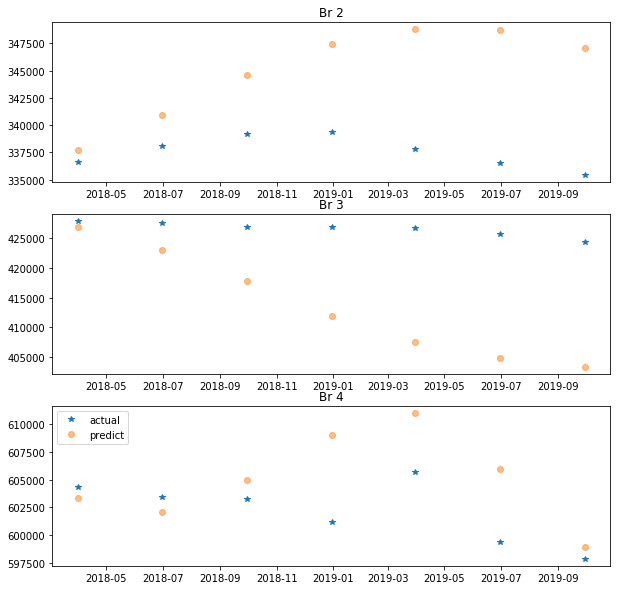

In [91]:
#Plot out-of-sample forecast vs actual values
fig, axs = plt.subplots(3, 1, figsize=(10,10))
axs[0].plot(df_unit_test.br1, '*', label = 'actual')
axs[0].plot(df_unit_fc_dynamic.br1, 'o', alpha = 0.5, label = 'predict')
axs[0].set_title('Br 2')

axs[1].plot(df_unit_test.br2, '*', label = 'actual')
axs[1].plot(df_unit_fc_dynamic.br2, 'o', alpha = 0.5, label = 'predict')
axs[1].set_title('Br 3')

axs[2].plot(df_unit_test.br3, '*', label = 'actual')
axs[2].plot(df_unit_fc_dynamic.br3, 'o', alpha = 0.5, label = 'predict')
axs[2].set_title('Br 4')
plt.legend(loc="upper left")

In [92]:
df_unit_test

,br1,br2,br3
saledate,,,
2018-03-31,336637.0,427856.0,604293.0
2018-06-30,338105.0,427623.0,603434.0
2018-09-30,339220.0,426970.0,603281.0
2018-12-31,339350.0,426936.0,601167.0
2019-03-31,337838.0,426669.0,605637.0
2019-06-30,336551.0,425659.0,599339.0
2019-09-30,335449.0,424412.0,597884.0


In [99]:
df_unit_raw_test['dynamic'] = df_unit_raw_test['price']
df_unit_raw_test

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,datesold,price,bedrooms,predict,dynamic
28223,2018-01-02,299000,1,299000,299000
28224,2018-01-03,354900,1,354900,354900
28225,2018-01-03,410000,1,410000,410000
28226,2018-01-04,350000,2,350000,350000
28227,2018-01-08,386000,1,386000,386000
...,...,...,...,...,...
29575,2019-07-25,500000,3,500000,500000
29576,2019-07-25,560000,2,560000,560000
29577,2019-07-26,464950,2,464950,464950
29578,2019-07-26,589000,2,589000,589000


In [101]:
#BED1
df_raw_test1 = df_unit_raw_test.loc[df_unit_raw_test['bedrooms'] == 1]
df_raw_test1.loc[df_raw_test1['datesold'] <=  '2018-03-31', 'dynamic'] = df_unit_fc_dynamic.br1[0]
df_raw_test1.loc[(df_raw_test1['datesold'] > '2018-03-31') & (df_raw_test1['datesold'] <=  '2018-06-30'), 'dynamic'] = df_unit_fc_dynamic.br1[1]
df_raw_test1.loc[(df_raw_test1['datesold'] > '2018-06-30') & (df_raw_test1['datesold'] <=  '2018-09-30'), 'dynamic'] = df_unit_fc_dynamic.br1[2]
df_raw_test1.loc[(df_raw_test1['datesold'] > '2018-09-30') & (df_raw_test1['datesold'] <=  '2018-12-31'), 'dynamic'] = df_unit_fc_dynamic.br1[3]
df_raw_test1.loc[(df_raw_test1['datesold'] > '2018-12-31') & (df_raw_test1['datesold'] <=  '2019-03-31'), 'dynamic'] = df_unit_fc_dynamic.br1[4]
df_raw_test1.loc[(df_raw_test1['datesold'] > '2019-03-31') & (df_raw_test1['datesold'] <=  '2019-06-30'), 'dynamic'] = df_unit_fc_dynamic.br1[5]
df_raw_test1.loc[(df_raw_test1['datesold'] >  '2019-06-30'), 'dynamic'] = df_unit_fc_dynamic.br1[6]
df_raw_test1

,datesold,price,bedrooms,predict,dynamic
28223,2018-01-02,299000,1,299000,337707.384474
28224,2018-01-03,354900,1,354900,337707.384474
28225,2018-01-03,410000,1,410000,337707.384474
28227,2018-01-08,386000,1,386000,337707.384474
28228,2018-01-09,295000,1,295000,337707.384474
...,...,...,...,...,...
29562,2019-07-23,310000,1,310000,347083.493458
29569,2019-07-24,590000,1,590000,347083.493458
29570,2019-07-25,172500,1,172500,347083.493458
29572,2019-07-25,321000,1,321000,347083.493458


In [102]:
df_unit_fc_dynamic

,br1,br2,br3
saledate,,,
2018-03-31,337707.384474,426834.589125,603338.216985
2018-06-30,340881.289262,423112.607256,602066.503880
2018-09-30,344564.453788,417867.309677,604953.108971
2018-12-31,347396.785334,411923.357076,609047.967604
2019-03-31,348759.604468,407597.096227,610978.842000
2019-06-30,348752.808104,404881.393951,605949.370315
2019-09-30,347083.493458,403396.515850,598936.926703


In [103]:
#BED2
df_raw_test2 = df_unit_raw_test.loc[df_unit_raw_test['bedrooms'] == 2]
df_raw_test2.loc[df_raw_test2['datesold'] <=  '2018-03-31', 'dynamic'] = df_unit_fc_dynamic.br2[0]
df_raw_test2.loc[(df_raw_test2['datesold'] > '2018-03-31') & (df_raw_test2['datesold'] <=  '2018-06-30'), 'dynamic'] = df_unit_fc_dynamic.br2[1]
df_raw_test2.loc[(df_raw_test2['datesold'] > '2018-06-30') & (df_raw_test2['datesold'] <=  '2018-09-30'), 'dynamic'] = df_unit_fc_dynamic.br2[2]
df_raw_test2.loc[(df_raw_test2['datesold'] > '2018-09-30') & (df_raw_test2['datesold'] <=  '2018-12-31'), 'dynamic'] = df_unit_fc_dynamic.br2[3]
df_raw_test2.loc[(df_raw_test2['datesold'] > '2018-12-31') & (df_raw_test2['datesold'] <=  '2019-03-31'), 'dynamic'] = df_unit_fc_dynamic.br2[4]
df_raw_test2.loc[(df_raw_test2['datesold'] > '2019-03-31') & (df_raw_test2['datesold'] <=  '2019-06-30'), 'dynamic'] = df_unit_fc_dynamic.br2[5]
df_raw_test2.loc[(df_raw_test2['datesold'] >  '2019-06-30'), 'dynamic'] = df_unit_fc_dynamic.br2[6]
df_raw_test2

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,datesold,price,bedrooms,predict,dynamic
28226,2018-01-04,350000,2,350000,426834.589125
28229,2018-01-09,400000,2,400000,426834.589125
28232,2018-01-10,325000,2,325000,426834.589125
28240,2018-01-11,420000,2,420000,426834.589125
28241,2018-01-12,254250,2,254250,426834.589125
...,...,...,...,...,...
29574,2019-07-25,475000,2,475000,403396.515850
29576,2019-07-25,560000,2,560000,403396.515850
29577,2019-07-26,464950,2,464950,403396.515850
29578,2019-07-26,589000,2,589000,403396.515850


In [104]:
#BED3
df_raw_test3 = df_unit_raw_test.loc[df_unit_raw_test['bedrooms'] == 3]
df_raw_test3.loc[df_raw_test3['datesold'] <=  '2018-03-31', 'dynamic'] = df_unit_fc_dynamic.br3[0]
df_raw_test3.loc[(df_raw_test3['datesold'] > '2018-03-31') & (df_raw_test3['datesold'] <=  '2018-06-30'), 'dynamic'] = df_unit_fc_dynamic.br3[1]
df_raw_test3.loc[(df_raw_test3['datesold'] > '2018-06-30') & (df_raw_test3['datesold'] <=  '2018-09-30'), 'dynamic'] = df_unit_fc_dynamic.br3[2]
df_raw_test3.loc[(df_raw_test3['datesold'] > '2018-09-30') & (df_raw_test3['datesold'] <=  '2018-12-31'), 'dynamic'] = df_unit_fc_dynamic.br3[3]
df_raw_test3.loc[(df_raw_test3['datesold'] > '2018-12-31') & (df_raw_test3['datesold'] <=  '2019-03-31'), 'dynamic'] = df_unit_fc_dynamic.br3[4]
df_raw_test3.loc[(df_raw_test3['datesold'] > '2019-03-31') & (df_raw_test3['datesold'] <=  '2019-06-30'), 'dynamic'] = df_unit_fc_dynamic.br3[5]
df_raw_test3.loc[(df_raw_test3['datesold'] >  '2019-06-30'), 'dynamic'] = df_unit_fc_dynamic.br3[6]
df_raw_test3

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,datesold,price,bedrooms,predict,dynamic
28236,2018-01-10,420000,3,420000,603338.216985
28237,2018-01-10,590000,3,590000,603338.216985
28263,2018-01-22,750000,3,750000,603338.216985
28269,2018-01-24,430000,3,430000,603338.216985
28274,2018-01-25,575000,3,575000,603338.216985
...,...,...,...,...,...
29529,2019-07-04,457500,3,457500,598936.926703
29559,2019-07-18,560000,3,560000,598936.926703
29564,2019-07-23,450000,3,450000,598936.926703
29567,2019-07-23,549950,3,549950,598936.926703


In [105]:
df_unit_raw_test.loc[df_unit_raw_test['bedrooms'] ==  1, 'dynamic'] = df_raw_test1.dynamic
df_unit_raw_test.loc[df_unit_raw_test['bedrooms'] ==  2, 'dynamic'] = df_raw_test2.dynamic
df_unit_raw_test.loc[df_unit_raw_test['bedrooms'] ==  3, 'dynamic'] = df_raw_test3.dynamic

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [106]:
del df_unit_raw_test['predict']

In [136]:
df_raw_test

,datesold,price,bedrooms,dynamic
20666,2018-01-03,1200000,4,8.355338e+05
20667,2018-01-05,850000,4,8.355338e+05
20668,2018-01-05,980000,5,1.044417e+06
20669,2018-01-08,330000,2,5.221681e+05
20670,2018-01-08,485000,3,6.206005e+05
...,...,...,...,...
24547,2019-07-26,610000,3,6.374321e+05
24548,2019-07-26,657500,4,8.415484e+05
24549,2019-07-27,610000,4,8.415484e+05
24550,2019-07-27,647500,4,8.415484e+05


In [137]:
df_raw_test.loc[df_raw_test['bedrooms'] ==  4].dynamic

20666    835533.776827
20667    835533.776827
20673    835533.776827
20676    835533.776827
20677    835533.776827
             ...      
24543    841548.439498
24544    841548.439498
24548    841548.439498
24549    841548.439498
24550    841548.439498
Name: dynamic, Length: 1667, dtype: float64

In [139]:
df_total_dynamic.loc[df_total_dynamic['bedrooms'] ==  4].dynamic

28304    535000.000000
28424    645000.000000
28772    300000.000000
29421    769500.000000
20666    835533.776827
             ...      
24543    841548.439498
24544    841548.439498
24548    841548.439498
24549    841548.439498
24550    841548.439498
Name: dynamic, Length: 1671, dtype: float64

In [108]:
df_total_dynamic = df_unit_raw_test.copy()
df_total_dynamic = df_total_dynamic.append(df_raw_test, ignore_index=True)

In [127]:
df_total_dynamic = df_unit_raw_test.copy()
df_total_dynamic = df_total_dynamic.append(df_raw_test)

In [128]:
df_total_dynamic

,datesold,price,bedrooms,dynamic
28223,2018-01-02,299000,1,3.377074e+05
28224,2018-01-03,354900,1,3.377074e+05
28225,2018-01-03,410000,1,3.377074e+05
28226,2018-01-04,350000,2,4.268346e+05
28227,2018-01-08,386000,1,3.377074e+05
...,...,...,...,...
24547,2019-07-26,610000,3,6.374321e+05
24548,2019-07-26,657500,4,8.415484e+05
24549,2019-07-27,610000,4,8.415484e+05
24550,2019-07-27,647500,4,8.415484e+05


In [109]:
df_total_dynamic

,datesold,price,bedrooms,dynamic
0,2018-01-02,299000,1,3.377074e+05
1,2018-01-03,354900,1,3.377074e+05
2,2018-01-03,410000,1,3.377074e+05
3,2018-01-04,350000,2,4.268346e+05
4,2018-01-08,386000,1,3.377074e+05
...,...,...,...,...
5238,2019-07-26,610000,3,6.374321e+05
5239,2019-07-26,657500,4,8.415484e+05
5240,2019-07-27,610000,4,8.415484e+05
5241,2019-07-27,647500,4,8.415484e+05


In [941]:
df_total

,datesold,price,bedrooms,predict
0,2018-01-02,299000,1,3.294026e+05
1,2018-01-03,354900,1,3.294026e+05
2,2018-01-03,410000,1,3.294026e+05
3,2018-01-04,350000,2,4.284225e+05
4,2018-01-08,386000,1,3.294026e+05
...,...,...,...,...
5224,2019-07-26,610000,3,6.337961e+05
5225,2019-07-26,657500,4,8.063584e+05
5226,2019-07-27,610000,4,8.063584e+05
5227,2019-07-27,647500,4,8.063584e+05


In [110]:
forecast_accuracy(df_total_dynamic.loc[df_total_dynamic['bedrooms'] ==  1].dynamic, df_total_dynamic.loc[df_total_dynamic['bedrooms'] ==  1].price)

{'MAPE': 19.14076847678953,
 'ME': 995.3325974022632,
 'MAE': 63903.858127658365,
 'MPE': 0.0655735143316833,
 'RMSE': 116850.23136791655}

In [111]:
forecast_accuracy(df_total_dynamic.loc[df_total_dynamic['bedrooms'] ==  2].dynamic, df_total_dynamic.loc[df_total_dynamic['bedrooms'] ==  2].price)

{'MAPE': 22.84633602489712,
 'ME': -6344.297250382676,
 'MAE': 100490.49223863392,
 'MPE': 0.06190858667939131,
 'RMSE': 136460.36658977775}

In [112]:
forecast_accuracy(df_total_dynamic.loc[df_total_dynamic['bedrooms'] ==  3].dynamic, df_total_dynamic.loc[df_total_dynamic['bedrooms'] ==  3].price)

{'MAPE': 20.808497933594623,
 'ME': -931.8140122112341,
 'MAE': 134994.3599302415,
 'MPE': 0.0721739866006874,
 'RMSE': 205948.94756274554}

In [130]:
forecast_accuracy(df_total_dynamic.loc[df_total_dynamic['bedrooms'] ==  4].dynamic, df_total_dynamic.loc[df_total_dynamic['bedrooms'] ==  4].price)

{'MAPE': 21.961485431721353,
 'ME': -724.7892213828779,
 'MAE': 174463.79202742164,
 'MPE': 0.08642606352579424,
 'RMSE': 264211.3163678601}

In [117]:
forecast_accuracy(df_raw_test.loc[df_raw_test['bedrooms'] ==  4].dynamic, df_raw_test.loc[df_raw_test['bedrooms'] ==  4].price)

{'MAPE': 22.01418245735236,
 'ME': -726.5283676849365,
 'MAE': 174882.42140241247,
 'MPE': 0.0866334446020409,
 'RMSE': 264528.1166211876}

In [114]:
forecast_accuracy(df_total_dynamic.loc[df_total_dynamic['bedrooms'] ==  5].dynamic, df_total_dynamic.loc[df_total_dynamic['bedrooms'] ==  5].price)

{'MAPE': 26.666758308066395,
 'ME': 25416.09601009223,
 'MAE': 267650.994564726,
 'MPE': 0.13101254997032735,
 'RMSE': 416589.52224413666}

In [115]:
forecast_accuracy(df_total_dynamic.loc[df_total_dynamic['bedrooms'] !=  5].dynamic, df_total_dynamic.loc[df_total_dynamic['bedrooms'] !=  5].price)

{'MAPE': 21.388126860917332,
 'ME': -1644.684997109724,
 'MAE': 135198.13641361805,
 'MPE': 0.07448839559739034,
 'RMSE': 211279.3272681201}

In [116]:
forecast_accuracy(df_total_dynamic.dynamic, df_total_dynamic.price)

{'MAPE': 21.737485074184693,
 'ME': 146.291735581393,
 'MAE': 143964.3278647791,
 'MPE': 0.07822936099266194,
 'RMSE': 230587.35071821787}

In [324]:
#SECOND WAY
import statsmodels.api as sm
model = sm.tsa.VARMAX(df_house_diff3, order=(2, 0), trend='c')
model_result = model.fit(maxiter=1000, disp=False)
model_result.summary()

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


Dep. Variable:,"['br2', 'br3', 'br4']",No. Observations:,39
Model:,VAR(2),Log Likelihood,443.656
,+ intercept,AIC,-833.311
Date:,"Tue, 07 Jul 2020",BIC,-788.395
Time:,23:43:20,HQIC,-817.196
Sample:,06-30-2008,,
,- 12-31-2017,,
Covariance Type:,opg,,
Ljung-Box (Q):,"45.73, 54.33, 69.88",Jarque-Bera (JB):,"1.91, 16.23, 2.03"
Prob(Q):,"0.18, 0.04, 0.00",Prob(JB):,"0.38, 0.00, 0.36"
Heteroskedasticity (H):,"0.36, 0.11, 0.73",Skew:,"-0.35, 0.65, -0.22"


In [323]:
for i in range(9):
    i += 1
    model = sm.tsa.VARMAX(df_house_diff3, order=(i,0))
    model_result = model.fit(maxiter=1000, disp=False)
    print('Order = ', i)
    print('AIC: ', model_result.aic)
    print('BIC: ', model_result.bic)
    print('HQIC: ', model_result.hqic)

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


Order =  1
AIC:  -795.6390551512746
BIC:  -765.694945520941
HQIC:  -784.8953662940481


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


Order =  2
AIC:  -833.3113307350394
BIC:  -788.3951662895389
HQIC:  -817.1957974491995


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


Order =  3
AIC:  -826.5616534826685
BIC:  -766.6734342220012
HQIC:  -805.0742757682153


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


Order =  4
AIC:  -821.0886028226972
BIC:  -746.2283287468631
HQIC:  -794.2293806796308


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


Order =  5
AIC:  -826.2152806415573
BIC:  -736.3829517505565
HQIC:  -793.9842140698777


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


Order =  6
AIC:  -786.801857306202
BIC:  -681.9974736000343
HQIC:  -749.198946305909
Order =  7
AIC:  -791.8791703348927
BIC:  -672.1027318135582
HQIC:  -748.9044149059864


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


Order =  8
AIC:  -707.9732059443182
BIC:  -573.2247126078169
HQIC:  -659.6266060867987


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Order =  9
AIC:  -715.5211939327116
BIC:  -565.8006457810435
HQIC:  -661.8027496465788


In [325]:
df_3d = model_result.forecast(steps=7)
df_2d = invert_transformation2(df_house_diff2, df_3d)
df_1d = invert_transformation2(df_house_diff1, df_2d)
df_fc_log = invert_transformation2(df_house_log, df_1d)
df_forecast_new = np.exp(df_fc_log)

In [326]:
df_3d

,br2,br3,br4
2018-03-31,-0.005186,-0.001408,0.003977
2018-06-30,0.018642,0.003771,0.000469
2018-09-30,-0.013447,-0.003769,-0.001956
2018-12-31,-0.002984,0.000026,0.000434
2019-03-31,0.011379,0.002260,0.000461
2019-06-30,-0.007850,-0.002724,-0.000684
2019-09-30,-0.001496,0.000538,-0.000165


In [327]:
df_forecast_new

,br2,br3,br4
2018-03-31,502148.500745,619269.815457,844925.703005
2018-06-30,500719.182066,622227.623668,861655.649510
2018-09-30,495555.544349,622258.579236,876509.813754
2018-12-31,485322.731368,619378.510512,889766.776099
2019-03-31,475719.329818,615016.158648,901762.464240
2019-06-30,463066.645663,607545.632383,911816.504651
2019-09-30,446950.309791,597402.213057,919708.820166


In [328]:
df_house_test

,br2,br3,br4
saledate,,,
2018-03-31,507248.0,619638.0,836056.0
2018-06-30,506116.0,622466.0,837295.0
2018-09-30,504318.0,624602.0,830727.0
2018-12-31,506001.0,626608.0,820924.0
2019-03-31,496133.0,628423.0,811121.0
2019-06-30,500158.0,630814.0,803925.0
2019-09-30,510712.0,631875.0,791446.0


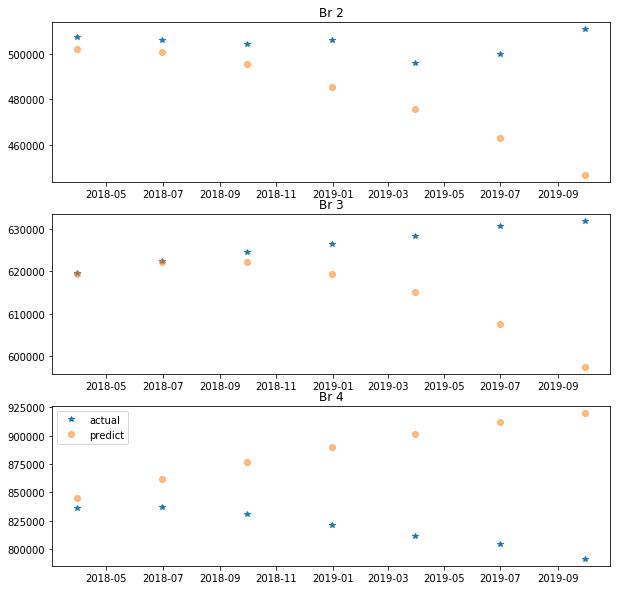

In [329]:
#Plot out-of-sample forecast vs actual values
fig, axs = plt.subplots(3, 1, figsize=(10,10))
axs[0].plot(df_house_test.br2, '*', label = 'actual')
axs[0].plot(df_forecast_new.br2, 'o', alpha = 0.5, label = 'predict')
axs[0].set_title('Br 2')

axs[1].plot(df_house_test.br3, '*', label = 'actual')
axs[1].plot(df_forecast_new.br3, 'o', alpha = 0.5, label = 'predict')
axs[1].set_title('Br 3')

axs[2].plot(df_house_test.br4, '*', label = 'actual')
axs[2].plot(df_forecast_new.br4, 'o', alpha = 0.5, label = 'predict')
axs[2].set_title('Br 4')
plt.legend(loc="upper left")

In [342]:
res =  VAR (df_house_diff3[:30]).fit(1)
mod = VAR(df_house_diff3)

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


In [345]:
mod.summary()

AttributeError: 'VAR' object has no attribute 'summary'

In [ ]:
forecasts = mod.predict(res.params)

In [347]:
res.params

,br2,br3,br4
const,0.000194,-0.000373,-0.000196
L1.br2,-0.706010,-0.100506,0.003083
L1.br3,0.988542,-0.462098,-0.145106
L1.br4,2.656056,0.623817,-0.383818


In [348]:
forecasts = mod.predict(res.params)

In [349]:
forecasts.shape

(38, 3)

In [351]:
df_house_234.shape

(49, 3)

In [352]:
df_log = np.log(df_house_234)
df_diff1 = df_log.diff().dropna()
df_diff2 = df_diff1.diff().dropna()
df_diff3 = df_diff2.diff().dropna()

In [354]:
df_diff3.tail(10)

,br2,br3,br4
saledate,,,
2017-06-30,-0.000925,0.000074,-0.003307
2017-09-30,0.001013,-0.003984,-0.000907
2017-12-31,-0.010316,-0.000114,-0.007476
2018-03-31,0.004918,-0.000814,-0.006576
2018-06-30,-0.000949,0.002371,0.003449
2018-09-30,0.002231,0.000624,-0.001225
2018-12-31,0.008215,0.000909,0.005361
2019-03-31,-0.029917,-0.000095,0.003853
2019-06-30,0.050801,0.001219,0.003245


In [357]:
df_diff3.shape

(46, 3)

In [360]:
df_house_diff3.tail()

,br2,br3,br4
saledate,,,
2016-12-31,0.001488,-0.000122,0.004211
2017-03-31,0.003995,-0.000085,0.004183
2017-06-30,-0.000925,0.000074,-0.003307
2017-09-30,0.001013,-0.003984,-0.000907
2017-12-31,-0.010316,-0.000114,-0.007476


In [361]:
df_diff3[:39].tail()

,br2,br3,br4
saledate,,,
2016-12-31,0.001488,-0.000122,0.004211
2017-03-31,0.003995,-0.000085,0.004183
2017-06-30,-0.000925,0.000074,-0.003307
2017-09-30,0.001013,-0.003984,-0.000907
2017-12-31,-0.010316,-0.000114,-0.007476


In [371]:
res =  VAR (df_diff3[:39]).fit(1)
mod = VAR(df_diff3)

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


In [373]:
res.params

,br2,br3,br4
const,-0.000145,-0.000463,-0.000303
L1.br2,-0.711367,-0.101608,0.001459
L1.br3,1.011926,-0.457002,-0.135519
L1.br4,2.436234,0.592479,-0.353395


In [372]:
forecasts = mod.predict(res.params)
forecasts

array([[ 3.39874858e-02, -1.58827364e-02, -4.87357182e-03],
       [-7.24992189e-02, -2.53913701e-03,  7.75348253e-03],
       [ 7.08944508e-02,  1.53578041e-02, -3.64745505e-03],
       [-3.51792454e-02, -1.98310580e-02, -2.87416580e-03],
       [-1.06381447e-02,  1.65690708e-02,  3.71064099e-03],
       [ 2.05414831e-02, -2.79637102e-03, -7.46057113e-04],
       [-1.14120622e-03, -3.34967084e-03, -4.09594834e-03],
       [-2.24834794e-02, -3.31708141e-03,  1.35694390e-03],
       [ 3.07008709e-02,  5.04027538e-03,  2.95416209e-03],
       [-3.09116530e-02, -6.32237316e-03, -9.51180641e-04],
       [ 1.27443126e-02,  2.89898317e-03, -1.50187471e-03],
       [-1.26337508e-02, -4.29849511e-04,  1.45449710e-03],
       [ 4.40291141e-03, -1.67700273e-03, -1.36566664e-03],
       [-6.80773398e-03,  4.15352286e-04,  1.42001044e-03],
       [ 2.80360110e-03,  2.10700433e-04, -1.01314744e-03],
       [ 2.45544612e-03, -2.48075646e-03, -4.36557187e-05],
       [ 1.11878621e-02,  1.40212619e-03